# HR Analytics
<br>
This repo contains the HR Analytics project as part of my data science portfolio. The objective is to predict employee promotion using a HR dataset from Analytics Vidha Website - <a href="https://datahack.analyticsvidhya.com/contest/wns-analytics-hackathon-2018-1/">Analytics Vidhya Website</a> - which contains employee data for 54,808 employees with various information about the employees.


# Problem Statement
Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

1. They first identify a set of employees based on recommendations/ past performance.
2. Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
3. At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. 

Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle. 

They have provided multiple attributes around Employee's past and current performance along with demographics. 

Now, The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process.


# Exploratory Data Analysis

## 1.  Understand the Problem Statement & Import Packages and Datasets :

In [1]:
# Warning Libraries :
import warnings
warnings.filterwarnings("ignore")

# Scientific and Data Manipulation Libraries :
import pandas as pd
import numpy as np
import math
import gc
import os
# Data Visualization Libraries :
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# path = r'C:\\Temporary D Drive\\D Drive\\ML Projects\\Deep Learning Project\\HR Analytics My Submissions\\'
test = pd.read_csv('/kaggle/input/analyticsvidhya-human-resource-analytics/test_2umaH9m.csv')
train = pd.read_csv('/kaggle/input/analyticsvidhya-human-resource-analytics/train_LZdllcl.csv')

# Look at the head() of the data
display('Train Head :',train.head())
display('Test Head :',test.head())

'Train Head :'

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


'Test Head :'

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [4]:
print("Total rows  in Train data", train.shape[0])
print("Unique ID in Train data",train.employee_id.nunique(), end = '\n\n')

print("Total rows  in Test data", test.shape[0])
print("Unique ID in Test data",test.employee_id.nunique(), end = '\n\n')

train_employee_ids = set(train['employee_id'].unique())
test_employee_ids = set(test['employee_id'].unique())

common_employee_ids = train_employee_ids.intersection(test_employee_ids)
count = len(common_employee_ids)
# Count has to be 0
print("Train ID present in Test ID", count)

Total rows  in Train data 54808
Unique ID in Train data 54808

Total rows  in Test data 23490
Unique ID in Test data 23490

Train ID present in Test ID 0


## 2.  Perform EDA (Exploratory Data Analysis) - Understanding the Datasets :

In [5]:
# Display Information of Train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [6]:
train = train.rename(columns={'KPIs_met >80%': 'KPI_met','awards_won?':'awards_won'})
test = test.rename(columns={'KPIs_met >80%': 'KPI_met','awards_won?':'awards_won'})

# These variable name change is done for smoothening internal coding operation. It is advisable to keep the variable name to 
# follow basic variable nomenclature norms while pulling the data from the source. 

In [7]:
# Display Information of Test data :

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPI_met               23490 non-null  int64  
 11  awards_won            23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [8]:
import pandas as pd

unique_col_value = {}
for col in train.columns:
    unique_col_value[col] = train[col].nunique()

df_unique_col_value = pd.DataFrame([unique_col_value]).T.reset_index()
df_unique_col_value.columns = ['Column', 'Unique Values']

display(df_unique_col_value)

,Column,Unique Values
0,employee_id,54808
1,department,9
2,region,34
3,education,3
4,gender,2
5,recruitment_channel,3
6,no_of_trainings,10
7,age,41
8,previous_year_rating,5
9,length_of_service,35


In [9]:
# Calculate total values
total_values = train.count()

# Calculate total missing values
total_missing = train.isnull().sum()

# Calculate percentage of missing values
percent_missing = round((total_missing / len(train)) * 100,2)

# Get data types
data_types = train.dtypes

# Create DataFrame
summary_df = pd.DataFrame({
    'Column': total_values.index,
    'Total Values': total_values,
    'Total Missing Values': total_missing,
    '% of Missing Values': percent_missing,
    'Data Types': data_types
})

summary_df.reset_index(drop=True, inplace=True)

merged_df = pd.merge(summary_df, df_unique_col_value, on='Column', how='left')
display(merged_df)
# merged_df.to_csv('merged_df.csv',index = False)

,Column,Total Values,Total Missing Values,% of Missing Values,Data Types,Unique Values
0,employee_id,54808,0,0.00,int64,54808
1,department,54808,0,0.00,object,9
2,region,54808,0,0.00,object,34
3,education,52399,2409,4.40,object,3
4,gender,54808,0,0.00,object,2
5,recruitment_channel,54808,0,0.00,object,3
6,no_of_trainings,54808,0,0.00,int64,10
7,age,54808,0,0.00,int64,41
8,previous_year_rating,50684,4124,7.52,float64,5
9,length_of_service,54808,0,0.00,int64,35


In [10]:
null_rows_count = len(train[(train['education'].isnull()) & (train['previous_year_rating'].isnull())])

print("Number of rows with NULL values in both 'Education' and 'previous_year_rating':", null_rows_count)

Number of rows with NULL values in both 'Education' and 'previous_year_rating': 385


## 3.  Check for Duplicate Rows from Train Data if present :

In [11]:
# Python Method 4 : Removes Data Duplicates while Retaining the First one - Similar to SQL DISTINCT :

def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return "Checked Duplicates"

# Remove Duplicates from "train" data :

remove_duplicate(train)

# No Duplicates at all !!!

BEFORE REMOVING DUPLICATES - No. of Rows =  54808
AFTER REMOVING DUPLICATES  - No. of Rows =  54808


'Checked Duplicates'

In [12]:
print("Total rows  in Train data", train.shape[0])
print("Unique ID in Train data",train.employee_id.nunique(), end = '\n\n')

Total rows  in Train data 54808
Unique ID in Train data 54808



In [13]:
print("Total rows  in Train data", test.shape[0])
print("Unique ID in Train data",test.employee_id.nunique(), end = '\n\n')

Total rows  in Train data 23490
Unique ID in Train data 23490



In [14]:
# Test duplicate after removing the employee id
train.drop(columns = ['employee_id'], inplace = True)

In [15]:
remove_duplicate(train)
# These duplicates can make an interesting case to be analysed because employee ID is different and rest other values are same.

BEFORE REMOVING DUPLICATES - No. of Rows =  54808
AFTER REMOVING DUPLICATES  - No. of Rows =  54690


'Checked Duplicates'

In [16]:
train.shape

(54690, 13)

## 4.  Fill/Impute Missing Values :
## Continuous - Mean/Median/Zero(Specific Value) | Categorical - Forward/BackFill/Others :

In [17]:
# Display the Missing Values in Train and Test :

print("Train : ")
display(train.isnull().sum())
print("Test : ")
display(test.isnull().sum())

# Missing Values are present in previous_year_rating and education columns in both Train and Test Data 
# Let's Handle it based on Intuition !

Train : 


department                 0
region                     0
education               2398
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4062
length_of_service          0
KPI_met                    0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

Test : 


employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPI_met                    0
awards_won                 0
avg_training_score         0
dtype: int64

In [18]:
train[pd.isna(train["previous_year_rating"]) == True].shape

(4062, 13)

In [19]:
train[pd.isna(train["previous_year_rating"]) == True].length_of_service.value_counts()

length_of_service
1    4062
Name: count, dtype: int64

In [20]:
test[pd.isna(test["previous_year_rating"]) == True].length_of_service.value_counts()

length_of_service
1    1812
Name: count, dtype: int64

In [21]:
# Why is Data Missing in Column "previous_year_rating" ? 
# 1. Data was not entered Because those employees were Freshers (i.e) length_of_service = 1 
# 2. No Data would have been there in the Data Source itself for these employees.
# Logically we are imputing with "0" as Freshers with 1 Year Experince may not have previous_year_rating at all!

# Filling Missing Values in Train and Test :

train["previous_year_rating"] = train["previous_year_rating"].fillna(0)
test["previous_year_rating"] = test["previous_year_rating"].fillna(0)

In [22]:
# Display Missing Values in Train and Test data :

display("Train : ", train.isnull().sum())
display("Test : ",test.isnull().sum())

'Train : '

department                 0
region                     0
education               2398
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPI_met                    0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

'Test : '

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPI_met                    0
awards_won                 0
avg_training_score         0
dtype: int64

In [23]:
from tabulate import tabulate

# Group columns by data type and count the number of columns for each data type
column_info = []
for dtype, columns in train.dtypes.groupby(train.dtypes):
    column_info.append((str(dtype), len(columns)))

# Print in tabular format
print(tabulate(column_info, headers=['Data Type', 'Number of Columns'], tablefmt='grid'))


+-------------+---------------------+
| Data Type   |   Number of Columns |
+=============+=====================+
| int64       |                   7 |
+-------------+---------------------+
| float64     |                   1 |
+-------------+---------------------+
| object      |                   5 |
+-------------+---------------------+


---
## Univariate/Bivariate/Multivariate Analysis

### Age
Age of employees is from 18 to 60 years old. The average age of ex-employees at 33.6 years old and 37.6 years old for current employees.

In [24]:
# Ex-Employees
print("Promoted Employees:")
print("Average Age of Ex-Employees = {:1.1f}".format(np.mean(train.loc[train['is_promoted'] == 1, 'age'])))
print("Standard Deviation = {:1.1f}".format(np.std(train.loc[train['is_promoted'] == 1, 'age'])))

Promoted Employees:
Average Age of Ex-Employees = 34.4
Standard Deviation = 7.1


In [25]:
# Active Employees
print("Non Promoted Employees:")
print("Average Age of Active Employees = {:1.1f}".format(np.mean(train.loc[train['is_promoted'] == 0, 'age'])))
print("Standard Deviation = {:1.1f}".format(np.std(train.loc[train['is_promoted'] == 0, 'age'])))

Non Promoted Employees:
Average Age of Active Employees = 34.9
Standard Deviation = 7.7


In [26]:
train_m = train[train.gender == 'm']

train_f = train[train.gender == 'f']

target_0 = train.loc[train["is_promoted"] == 0]
target_1 = train.loc[train["is_promoted"] == 1]

target_0_m = train_m.loc[train_m["is_promoted"] == 0]
target_1_m = train_m.loc[train_m["is_promoted"] == 1]

target_0_f = train_f.loc[train_f["is_promoted"] == 0]
target_1_f = train_f.loc[train_f["is_promoted"] == 1]

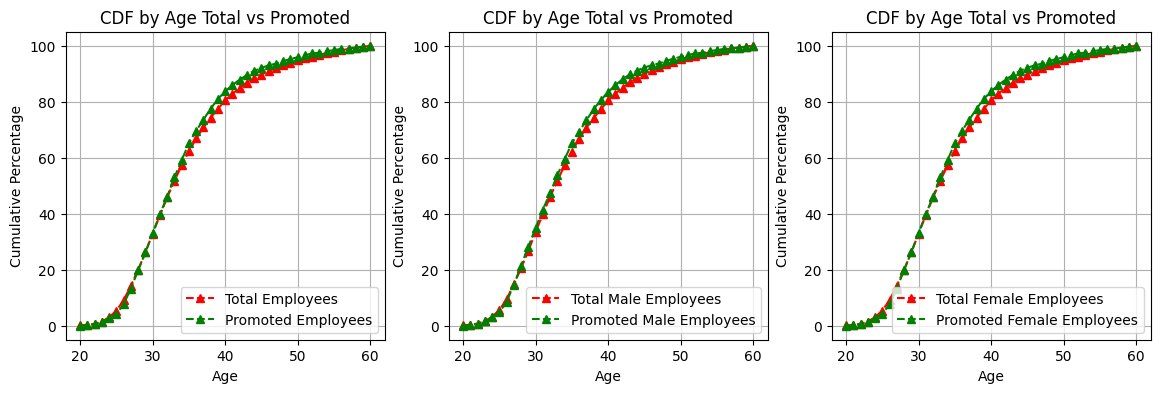

In [27]:
# Total employees
total_employees = len(train)

# Percentage of employees in each age category
age_counts = train['age'].value_counts().sort_index()
percentage_employees = (age_counts / total_employees) * 100
cumulative_percent_age = np.cumsum(percentage_employees)


# Percentage of employees in each age category
promoted_age_counts = target_1['age'].value_counts().sort_index()
percentage_employees_prom = (promoted_age_counts / len(target_1)) * 100
cumulative_age_promoted = np.cumsum(percentage_employees_prom)
#=======================================================================
# Males
# Percentage of employees in each age category
age_counts_m = train_m['age'].value_counts().sort_index()
percentage_employees_m = (age_counts_m / len(train_m)) * 100
cumulative_percent_age_m = np.cumsum(percentage_employees_m)


# Percentage of employees in each age category
promoted_age_counts_m = target_1_m['age'].value_counts().sort_index()
percentage_employees_prom_m = (promoted_age_counts_m / len(target_1_m)) * 100
cumulative_age_promoted_m = np.cumsum(percentage_employees_prom_m)
#=========================================================================
# Percentage of employees in each age category
# Female
# Percentage of employees in each age category
age_counts_f = train_f['age'].value_counts().sort_index()
percentage_employees_f = (age_counts_f / len(train_f)) * 100
cumulative_percent_age_f = np.cumsum(percentage_employees_f)


# Percentage of employees in each age category
promoted_age_counts_f = target_1_f['age'].value_counts().sort_index()
percentage_employees_prom_f = (promoted_age_counts_f / len(target_1_f)) * 100
cumulative_age_promoted_f = np.cumsum(percentage_employees_prom_f)
#=========================================================================

# Plotting the cumulative distribution functions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # Create subplots


# Plotting for total employees
axes[0].plot(np.array(cumulative_percent_age.index), cumulative_percent_age.values, marker='^', color='red', linestyle='--', label='Total Employees')
axes[0].plot(np.array(cumulative_age_promoted.index), cumulative_age_promoted.values, marker='^', color='green', linestyle='--', label='Promoted Employees')

axes[0].set_title('CDF by Age Total vs Promoted')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Cumulative Percentage')
axes[0].grid(True)
axes[0].legend()
axes[0].legend(loc='lower right')

# Plotting for total employees
axes[1].plot(np.array(cumulative_percent_age_m.index), cumulative_percent_age_m.values, marker='^', color='red', linestyle='--', label='Total Male Employees')
axes[1].plot(np.array(cumulative_age_promoted_m.index), cumulative_age_promoted_m.values, marker='^', color='green', linestyle='--', label='Promoted Male Employees')

axes[1].set_title('CDF by Age Total vs Promoted')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Cumulative Percentage')
axes[1].grid(True)
axes[1].legend()
axes[1].legend(loc='lower right')

# Plotting for total employees
axes[2].plot(np.array(cumulative_percent_age.index), cumulative_percent_age.values, marker='^', color='red', linestyle='--', label='Total Female Employees')
axes[2].plot(np.array(cumulative_age_promoted.index), cumulative_age_promoted.values, marker='^', color='green', linestyle='--', label='Promoted Female Employees')

axes[2].set_title('CDF by Age Total vs Promoted')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Cumulative Percentage')
axes[2].grid(True)
axes[2].legend()
axes[2].legend(loc='lower right')

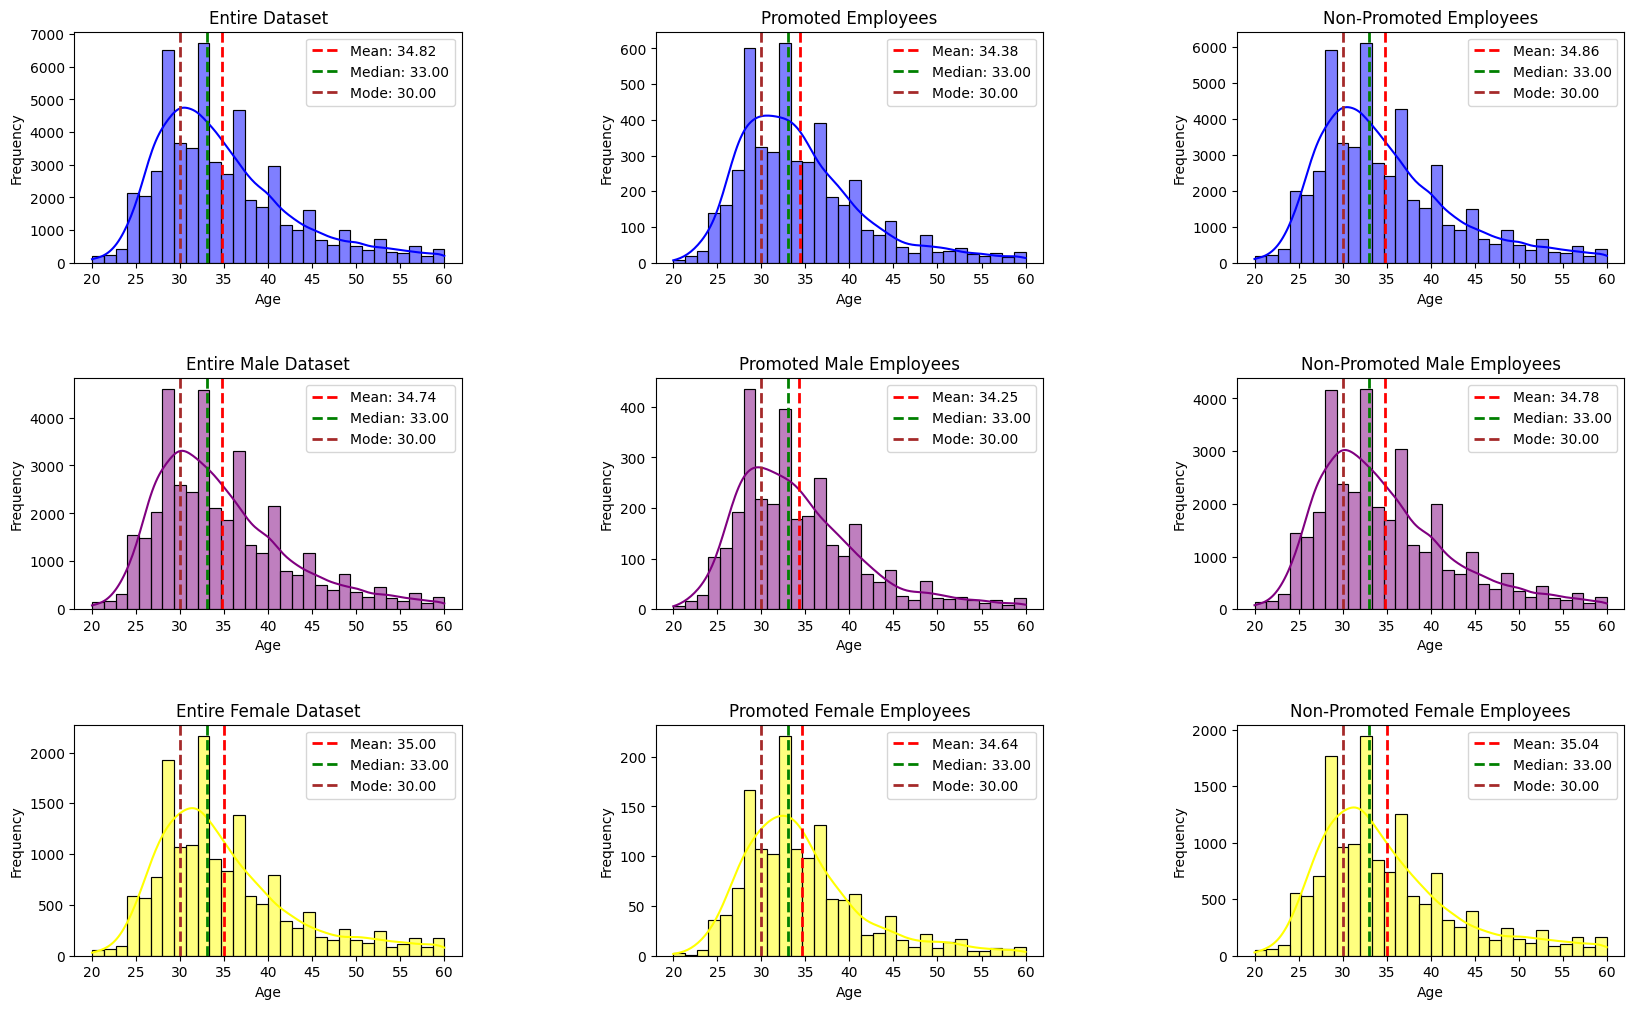

In [28]:
# Plotting the histograms
axes.flatten()
fig, axes = plt.subplots(3, 3, figsize=(20, 12))  # Change figure size to (20, 12)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Plotting for the entire dataset
sns.histplot(train['age'], bins=30, kde=True, color='blue', ax=axes[0, 0])  # Changed indexing to [0, 0]
mean_age = np.mean(train['age'])
median_age = np.median(train['age'])
mode_age = train['age'].mode()[0]
axes[0, 0].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[0, 0].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[0, 0].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[0, 0].set_title('Entire Dataset')

# Plotting for Promoted Employees
sns.histplot(target_1['age'], bins=30, kde=True, color='blue', ax=axes[0, 1])  # Changed indexing to [0, 1]
mean_age = np.mean(target_1['age'])
median_age = np.median(target_1['age'])
mode_age = target_1['age'].mode()[0]
axes[0, 1].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[0, 1].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[0, 1].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[0, 1].set_title('Promoted Employees')

# Plotting for Non-Promoted Employees
sns.histplot(target_0['age'], bins=30, kde=True, color='blue', ax=axes[0, 2])  # Changed indexing to [0, 2]
mean_age = np.mean(target_0['age'])
median_age = np.median(target_0['age'])
mode_age = target_0['age'].mode()[0]
axes[0, 2].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[0, 2].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[0, 2].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[0, 2].set_title('Non-Promoted Employees')

# Plotting for the entire dataset
sns.histplot(train_m['age'], bins=30, kde=True, color='purple', ax=axes[1, 0])  # Changed indexing to [1, 0]
mean_age = np.mean(train_m['age'])
median_age = np.median(train_m['age'])
mode_age = train_m['age'].mode()[0]
axes[1, 0].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[1, 0].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[1, 0].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[1, 0].set_title('Entire Male Dataset')

# Plotting for Promoted Employees
sns.histplot(target_1_m['age'], bins=30, kde=True, color='purple', ax=axes[1, 1])  # Changed indexing to [1, 1]
mean_age = np.mean(target_1_m['age'])
median_age = np.median(target_1_m['age'])
mode_age = target_1['age'].mode()[0]
axes[1, 1].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[1, 1].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[1, 1].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[1, 1].set_title('Promoted Male Employees')

# Plotting for Non-Promoted Employees
sns.histplot(target_0_m['age'], bins=30, kde=True, color='purple', ax=axes[1, 2])  # Changed indexing to [1, 2]
mean_age = np.mean(target_0_m['age'])
median_age = np.median(target_0_m['age'])
mode_age = target_0['age'].mode()[0]
axes[1, 2].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[1, 2].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[1, 2].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[1, 2].set_title('Non-Promoted Male Employees')

# Plotting for the entire dataset
sns.histplot(train_f['age'], bins=30, kde=True, color='yellow', ax=axes[2, 0])  # Changed indexing to [2, 0]
mean_age = np.mean(train_f['age'])
median_age = np.median(train_f['age'])
mode_age = train_m['age'].mode()[0]
axes[2, 0].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[2, 0].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[2, 0].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[2, 0].set_title('Entire Female Dataset')

# Plotting for Promoted Employees
sns.histplot(target_1_f['age'], bins=30, kde=True, color='yellow', ax=axes[2, 1])  # Changed indexing to [2, 1]
mean_age = np.mean(target_1_f['age'])
median_age = np.median(target_1_f['age'])
mode_age = target_1['age'].mode()[0]
axes[2, 1].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[2, 1].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[2, 1].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[2, 1].set_title('Promoted Female Employees')

# Plotting for Non-Promoted Employees
sns.histplot(target_0_f['age'], bins=30, kde=True, color='yellow', ax=axes[2, 2])  # Changed indexing to [2, 2]
mean_age = np.mean(target_0_f['age'])
median_age = np.median(target_0_f['age'])
mode_age = target_0['age'].mode()[0]
axes[2, 2].axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.2f}')
axes[2, 2].axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.2f}')
axes[2, 2].axvline(mode_age, color='brown', linestyle='dashed', linewidth=2, label=f'Mode: {mode_age:.2f}')
axes[2, 2].set_title('Non-Promoted Female Employees')

# Adding labels and title
for ax_row in axes:  # Loop over each row of subplots
    for ax in ax_row:  # Loop over each subplot in the row
        ax.set_xlabel('Age')
        ax.set_ylabel('Frequency')
        ax.legend()
plt.show()


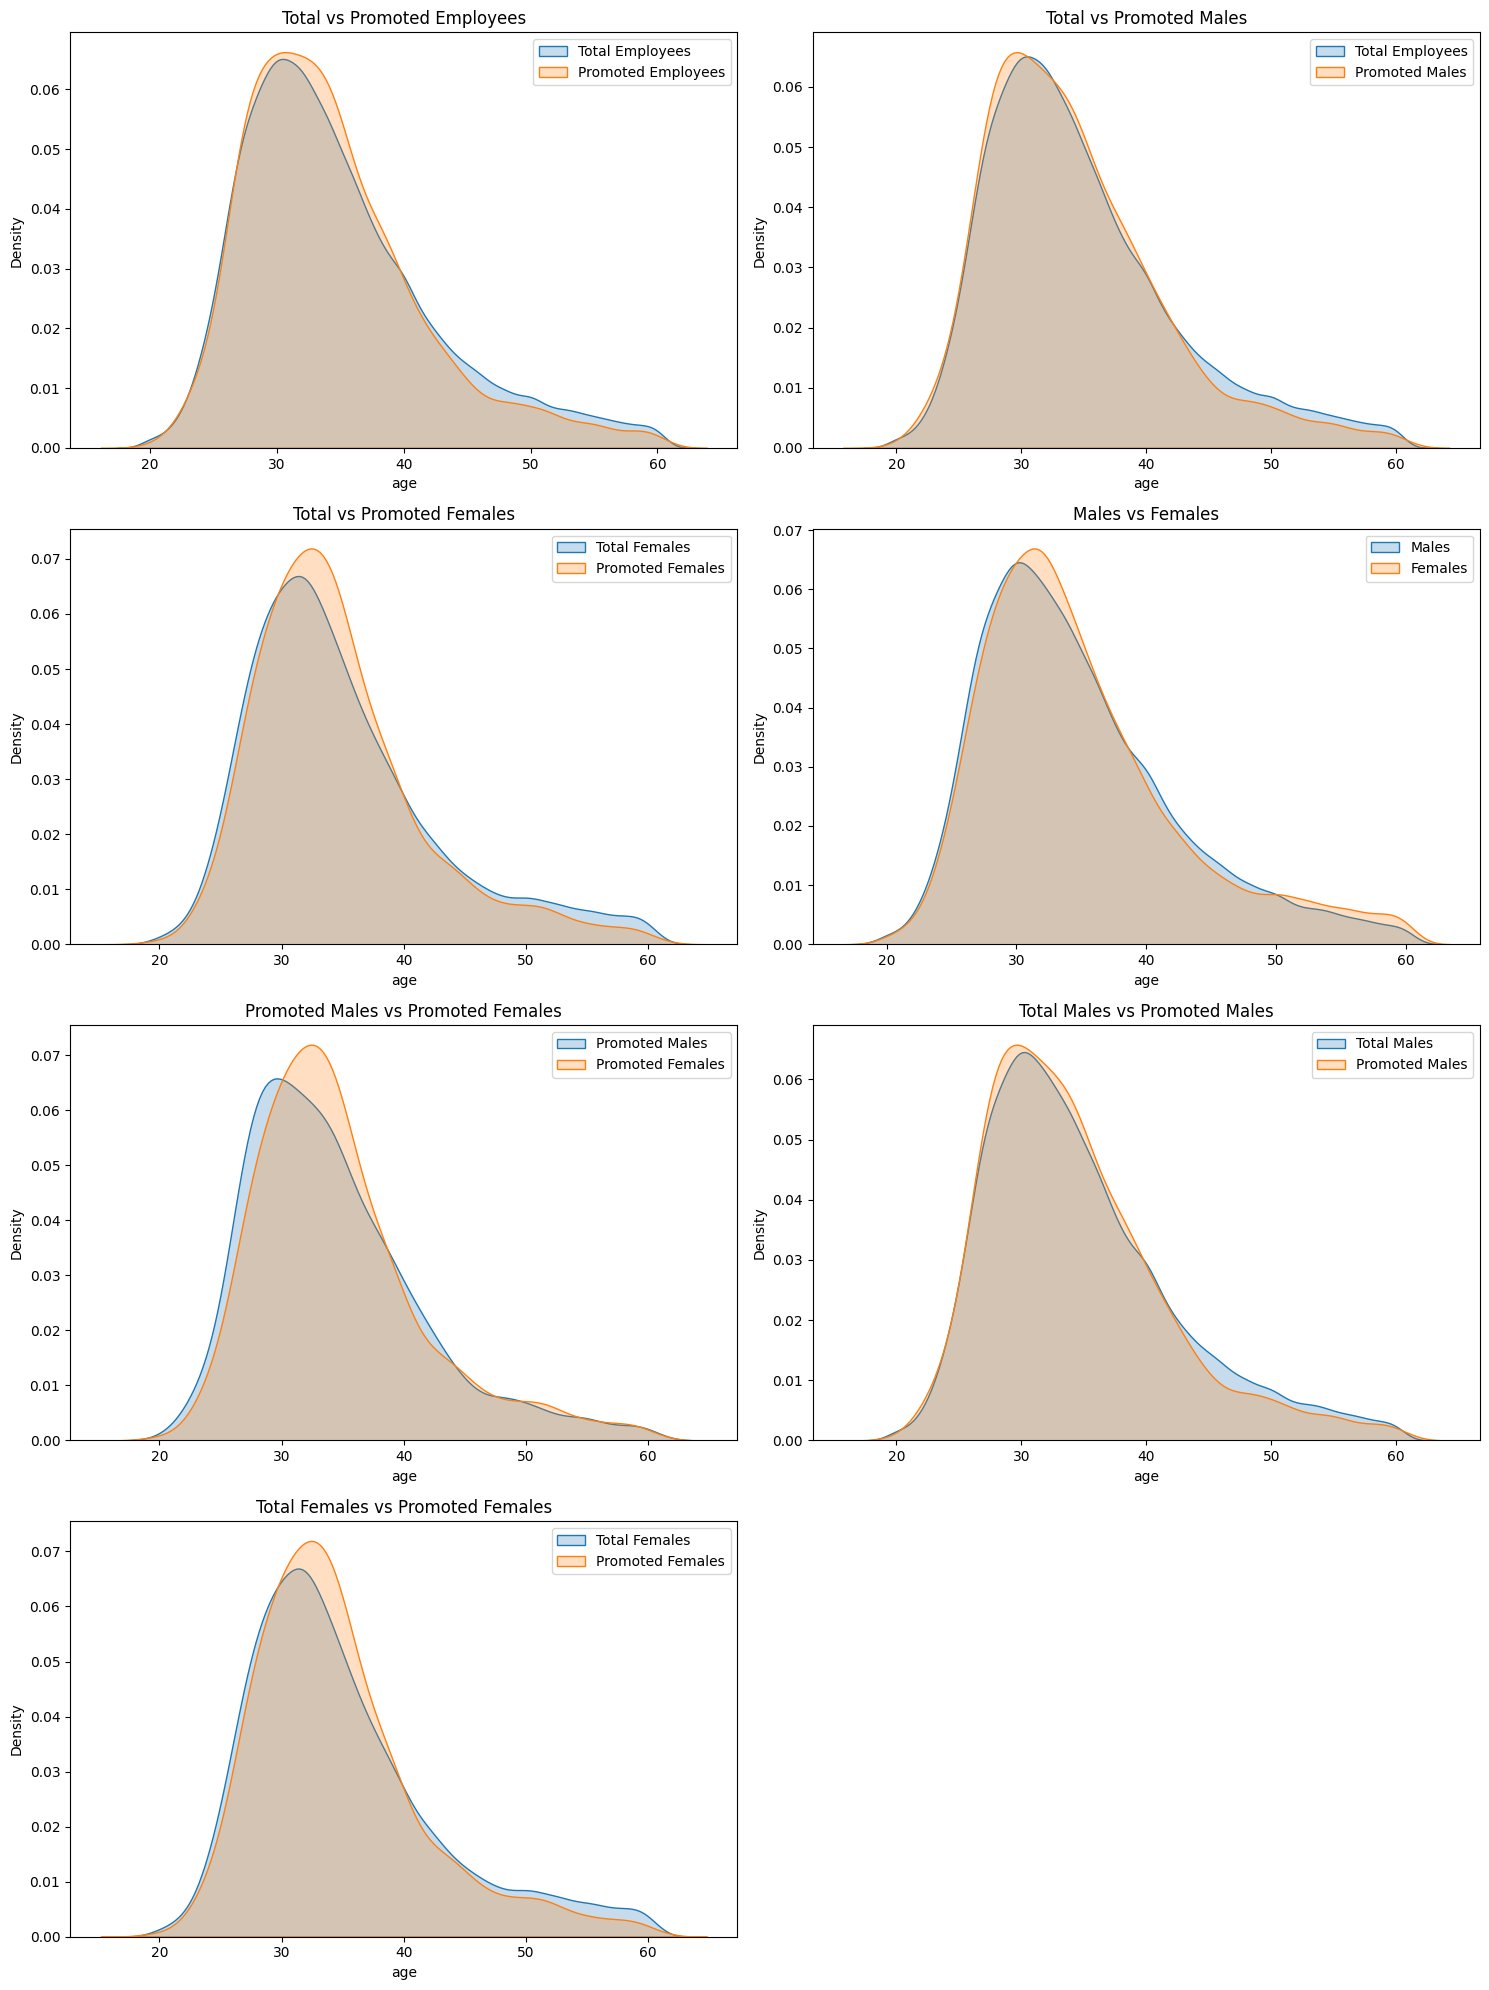

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Plot 1: Age of total employees vs age of promoted employees only
sns.kdeplot(train['age'], ax=axes[0, 0], label='Total Employees', shade=True)
sns.kdeplot(target_1['age'], ax=axes[0, 0], label='Promoted Employees', shade=True)
axes[0, 0].set_title('Total vs Promoted Employees')
axes[0, 0].legend()

# Plot 2: Age of total employees vs age of promoted males employees only
sns.kdeplot(train['age'], ax=axes[0, 1], label='Total Employees', shade=True)
sns.kdeplot(target_1[(target_1['gender'] == 'm')]['age'], ax=axes[0, 1], label='Promoted Males', shade=True)
axes[0, 1].set_title('Total vs Promoted Males')
axes[0, 1].legend()

# Plot 3: Age of total employees vs age of promoted females
sns.kdeplot(train[train['gender'] == 'f']['age'], ax=axes[1, 0], label='Total Females', shade=True)
sns.kdeplot(target_1[(target_1['gender'] == 'f')]['age'], ax=axes[1, 0], label='Promoted Females', shade=True)
axes[1, 0].set_title('Total vs Promoted Females')
axes[1, 0].legend()

# Plot 4: Age of males vs age of females
sns.kdeplot(train[train['gender'] == 'm']['age'], ax=axes[1, 1], label='Males', shade=True)
sns.kdeplot(train[train['gender'] == 'f']['age'], ax=axes[1, 1], label='Females', shade=True)
axes[1, 1].set_title('Males vs Females')
axes[1, 1].legend()

# Plot 5: Age of promoted males vs age of promoted females
sns.kdeplot(target_1[target_1['gender'] == 'm']['age'], ax=axes[2, 0], label='Promoted Males', shade=True)
sns.kdeplot(target_1[target_1['gender'] == 'f']['age'], ax=axes[2, 0], label='Promoted Females', shade=True)
axes[2, 0].set_title('Promoted Males vs Promoted Females')
axes[2, 0].legend()

# Plot 6: Age of males vs promoted males
sns.kdeplot(train[train['gender'] == 'm']['age'], ax=axes[2, 1], label='Total Males', shade=True)
sns.kdeplot(target_1[(target_1['gender'] == 'm')]['age'], ax=axes[2, 1], label='Promoted Males', shade=True)
axes[2, 1].set_title('Total Males vs Promoted Males')
axes[2, 1].legend()

# Plot 7: Age of females vs promoted females
sns.kdeplot(train[train['gender'] == 'f']['age'], ax=axes[3, 0], label='Total Females', shade=True)
sns.kdeplot(target_1[(target_1['gender'] == 'f')]['age'], ax=axes[3, 0], label='Promoted Females', shade=True)
axes[3, 0].set_title('Total Females vs Promoted Females')
axes[3, 0].legend()

# Hide the empty subplot
axes[3, 1].axis('off')

plt.tight_layout()
plt.show()


### Gender
Gender distribution shows that the dataset features a higher relative proportion of male ex-employees than female ex-employees, with normalised gender distribution of ex-employees in the dataset at 17% for Males and 15% for Females.

In [31]:
# Gender of employees
train['gender'].value_counts(normalize=True)

gender
m    0.702194
f    0.297806
Name: proportion, dtype: float64

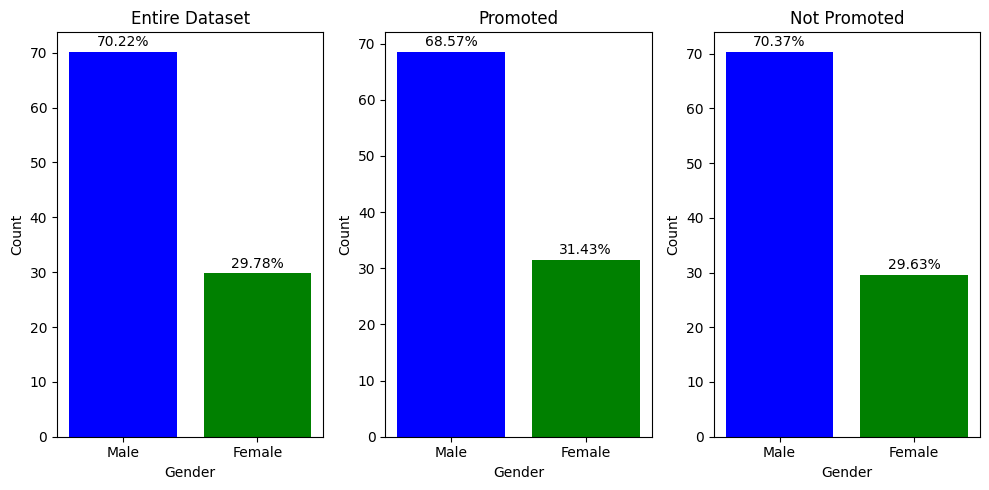

In [100]:
import matplotlib.pyplot as plt
train['gender'] = train['gender'].replace({'m': 'Male', 'f': 'Female'})
# Filter DataFrame based on promotion status
promoted = train[train['is_promoted'] == 1]
not_promoted = train[train['is_promoted'] == 0]

# Count the number of males and females in each group
gender_counts = train['gender'].value_counts()
promoted_gender_counts = promoted['gender'].value_counts()
not_promoted_gender_counts = not_promoted['gender'].value_counts()

# Calculate percentage values
gender_percentage = (gender_counts / gender_counts.sum()) * 100
promoted_gender_percentage = (promoted_gender_counts / promoted_gender_counts.sum()) * 100
not_promoted_gender_percentage = (not_promoted_gender_counts / not_promoted_gender_counts.sum()) * 100

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

bars = axes[0].bar(gender_counts.index, gender_percentage.values, color=['blue', 'green'])
axes[0].set_title('Entire Dataset')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(bars, gender_percentage):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')


# Bar chart for promoted
promoted_bars = axes[1].bar(promoted_gender_counts.index, promoted_gender_percentage.values, color=['blue', 'green'])
axes[1].set_title('Promoted')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars, promoted_gender_percentage):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Bar chart for not promoted
not_promoted_bars = axes[2].bar(not_promoted_gender_counts.index, not_promoted_gender_percentage.values, color=['blue', 'green'])
axes[2].set_title('Not Promoted')
axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(not_promoted_bars, not_promoted_gender_percentage):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')
    

# Show plot
plt.tight_layout()
plt.show()


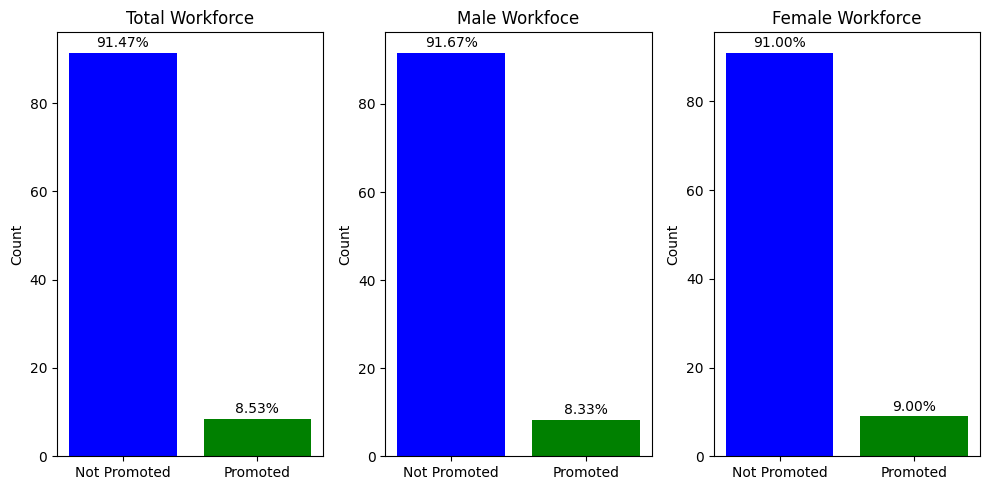

In [101]:
# train['gender'] = train['gender'].replace({'m': 'Male', 'f': 'Female'})


# Count the number of males and females in each group
promotion_counts = train['is_promoted'].value_counts()
promotion_counts_m = train_m['is_promoted'].value_counts()
promotion_counts_f = train_f['is_promoted'].value_counts()

# Calculate percentage values
promotion_percentage = (promotion_counts / promotion_counts.sum()) * 100
promoted_male_percentage = (promotion_counts_m / promotion_counts_m.sum()) * 100
promoted_female_percentage = (promotion_counts_f / promotion_counts_f.sum()) * 100

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
bar_width = 0.8

bars = axes[0].bar(["Not Promoted","Promoted"], promotion_percentage.values,width=bar_width ,color=['blue', 'green'])
axes[0].set_title('Total Workforce')
# axes[0].set_xlabel('Total Workforce')
axes[0].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(bars, promotion_percentage):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')


# Bar chart for promoted
promoted_bars = axes[1].bar(["Not Promoted","Promoted"], promoted_male_percentage.values,width=bar_width ,color=['blue', 'green'])
axes[1].set_title('Male Workfoce')
# axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars, promoted_male_percentage):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Bar chart for not promoted
not_promoted_bars = axes[2].bar(["Not Promoted","Promoted"], promoted_female_percentage.values,width=bar_width ,color=['blue', 'green'])
axes[2].set_title('Female Workforce')
# axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(not_promoted_bars, promoted_female_percentage):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')
    

# Show plot
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.show()

### Previous Year Rating
The dataset features three marital status: Married (673 employees), Single (470 employees), Divorced (327 employees). 
Single employees show the largest proportion of leavers at 25%.

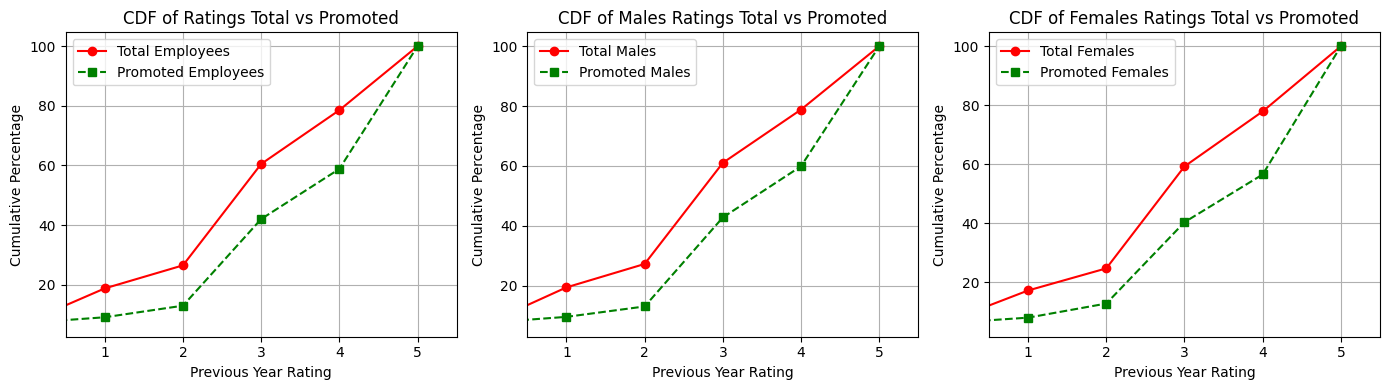

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Total employees
total_employees = len(train)

# Percentage of employees in each rating category
rating_counts = train['previous_year_rating'].value_counts().sort_index(ascending=True)
percentage_employees = (rating_counts / total_employees) * 100
cumulative_percentage_employees = np.cumsum(percentage_employees)

rating_counts_p = target_1['previous_year_rating'].value_counts().sort_index(ascending=True)
percentage_employees_p = (rating_counts_p / len(target_1)) * 100
cumulative_percentage_promoted = np.cumsum(percentage_employees_p)

# Percentage of male employees in each rating category
male_counts = train[train['gender'] == 'Male']['previous_year_rating'].value_counts().sort_index()
percentage_male = (male_counts / male_counts.sum()) * 100
cumulative_percentage_males = np.cumsum(percentage_male)

rating_counts_pm = target_1_m['previous_year_rating'].value_counts().sort_index()
percentage_employees_pm = (rating_counts_pm / len(target_1_m)) * 100
cumulative_percentage_promoted_m = np.cumsum(percentage_employees_pm)

# Percentage of female employees in each rating category
female_counts = train[train['gender'] == 'Female']['previous_year_rating'].value_counts().sort_index()
percentage_female = (female_counts / female_counts.sum()) * 100
cumulative_percentage_females = np.cumsum(percentage_female)

rating_counts_pf = target_1_f['previous_year_rating'].value_counts().sort_index()
percentage_employees_pf = (rating_counts_pf / len(target_1_f)) * 100
cumulative_percentage_promoted_f = np.cumsum(percentage_employees_pf)

# Plotting the cumulative distribution functions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # Create subplots

# Plotting for total employees
axes[0].plot(cumulative_percentage_employees.index, cumulative_percentage_employees.values, marker='o', color='red', linestyle='-', label='Total Employees')
axes[0].plot(cumulative_percentage_promoted.index, cumulative_percentage_promoted.values, marker='s', color='green', linestyle='--', label='Promoted Employees')

axes[0].set_title('CDF of Ratings Total vs Promoted')
axes[0].set_xlabel('Previous Year Rating')
axes[0].set_ylabel('Cumulative Percentage')
axes[0].grid(True)
axes[0].set_xticks(np.arange(1, 6))  # Set x-ticks to match rating scale
axes[0].set_xlim(0.5, 5.5)  # Adjust x-axis limits for better visualization
axes[0].legend()

# Total males vs Promoted Males
axes[1].plot(cumulative_percentage_males.index, cumulative_percentage_males.values, marker='o', color='red', linestyle='-', label='Total Males')
axes[1].plot(cumulative_percentage_promoted_m.index, cumulative_percentage_promoted_m.values, marker='s', color='green', linestyle='--', label='Promoted Males')

axes[1].set_title('CDF of Males Ratings Total vs Promoted')
axes[1].set_xlabel('Previous Year Rating')
axes[1].set_ylabel('Cumulative Percentage')
axes[1].grid(True)
axes[1].set_xticks(np.arange(1, 6))  # Set x-ticks to match rating scale
axes[1].set_xlim(0.5, 5.5)  # Adjust x-axis limits for better visualization
axes[1].legend()


# Plotting the cumulative distribution functions for promoted employees
axes[2].plot(cumulative_percentage_females.index, cumulative_percentage_females.values, marker='o', color='red', linestyle='-', label='Total Females')
axes[2].plot(cumulative_percentage_promoted_f.index, cumulative_percentage_promoted_f.values, marker='s', color='green', linestyle='--', label='Promoted Females')

axes[2].set_title('CDF of Females Ratings Total vs Promoted')
axes[2].set_xlabel('Previous Year Rating')
axes[2].set_ylabel('Cumulative Percentage')
axes[2].grid(True)
axes[2].set_xticks(np.arange(1, 6))  # Set x-ticks to match rating scale
axes[2].set_xlim(0.5, 5.5)  # Adjust x-axis limits for better visualization
axes[2].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

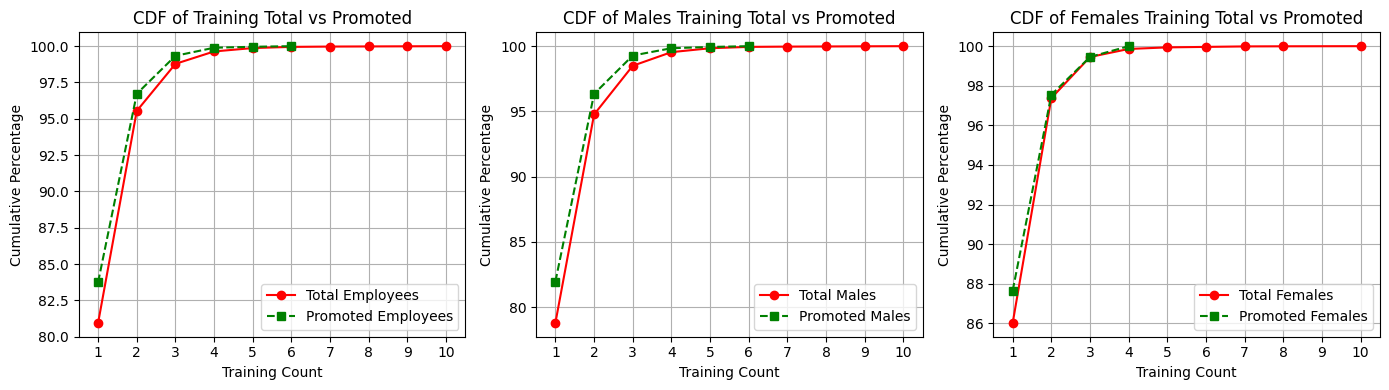

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Total employees
total_employees = len(train)

# Percentage of employees in each number of trainings category
trainings_counts = train['no_of_trainings'].value_counts().sort_index()
percentage_trainings = (trainings_counts / total_employees) * 100
cumulative_percentage_trainings = np.cumsum(percentage_trainings)

# Percentage of male employees in each number of trainings category
male_counts_trainings = train[train['gender'] == 'Male']['no_of_trainings'].value_counts().sort_index()
percentage_male_trainings = (male_counts_trainings / male_counts_trainings.sum()) * 100
cumulative_percentage_male_trainings = np.cumsum(percentage_male_trainings)

# Percentage of female employees in each number of trainings category
female_counts_trainings = train[train['gender'] == 'Female']['no_of_trainings'].value_counts().sort_index()
percentage_female_trainings = (female_counts_trainings / female_counts_trainings.sum()) * 100
cumulative_percentage_female_trainings = np.cumsum(percentage_female_trainings)


# Filter data for promoted employees
promoted_data = train[train['is_promoted'] == 1]

# Total promoted employees
total_promoted = len(promoted_data)

# Percentage of promoted employees in each number of trainings category
trainings_counts_promoted = promoted_data['no_of_trainings'].value_counts().sort_index()
percentage_promoted_trainings = (trainings_counts_promoted / total_promoted) * 100
cumulative_percentage_promoted_trainings = np.cumsum(percentage_promoted_trainings)

# Percentage of male promoted employees in each number of trainings category
male_counts_trainings_promoted = promoted_data[promoted_data['gender'] == 'Male']['no_of_trainings'].value_counts().sort_index()
percentage_male_promoted_trainings = (male_counts_trainings_promoted / male_counts_trainings_promoted.sum()) * 100
cumulative_percentage_male_promoted_trainings = np.cumsum(percentage_male_promoted_trainings)

# Percentage of female promoted employees in each number of trainings category
female_counts_trainings_promoted = promoted_data[promoted_data['gender'] == 'Female']['no_of_trainings'].value_counts().sort_index()
percentage_female_promoted_trainings = (female_counts_trainings_promoted / female_counts_trainings_promoted.sum()) * 100
cumulative_percentage_female_promoted_trainings = np.cumsum(percentage_female_promoted_trainings)

# Plotting the cumulative distribution functions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # Create subplots

# Plotting for total employees
axes[0].plot(cumulative_percentage_trainings.index, cumulative_percentage_trainings.values, marker='o', color='red', linestyle='-', label='Total Employees')
axes[0].plot(cumulative_percentage_promoted_trainings.index, cumulative_percentage_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Employees')

axes[0].set_title('CDF of Training Total vs Promoted')
axes[0].set_xlabel('Training Count')
axes[0].set_ylabel('Cumulative Percentage')
axes[0].grid(True)
axes[0].set_xticks(np.arange(1, 11))  # Set x-ticks to match rating scale
axes[0].set_xlim(0.5, 10.5)  # Adjust x-axis limits for better visualization
axes[0].legend()

# Total males vs Promoted Males
axes[1].plot(cumulative_percentage_male_trainings.index, cumulative_percentage_male_trainings.values, marker='o', color='red', linestyle='-', label='Total Males')
axes[1].plot(cumulative_percentage_male_promoted_trainings.index, cumulative_percentage_male_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Males')

axes[1].set_title('CDF of Males Training Total vs Promoted')
axes[1].set_xlabel('Training Count')
axes[1].set_ylabel('Cumulative Percentage')
axes[1].grid(True)
axes[1].set_xticks(np.arange(1, 11))  # Set x-ticks to match rating scale
axes[1].set_xlim(0.5, 10.5)  # Adjust x-axis limits for better visualization
axes[1].legend()


# Plotting the cumulative distribution functions for promoted employees
axes[2].plot(cumulative_percentage_female_trainings.index, cumulative_percentage_female_trainings.values, marker='o', color='red', linestyle='-', label='Total Females')
axes[2].plot(cumulative_percentage_female_promoted_trainings.index, cumulative_percentage_female_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Females')

axes[2].set_title('CDF of Females Training Total vs Promoted')
axes[2].set_xlabel('Training Count')
axes[2].set_ylabel('Cumulative Percentage')
axes[2].grid(True)
axes[2].set_xticks(np.arange(1, 11))  # Set x-ticks to match rating scale
axes[2].set_xlim(0.5, 10.5)  # Adjust x-axis limits for better visualization
axes[2].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


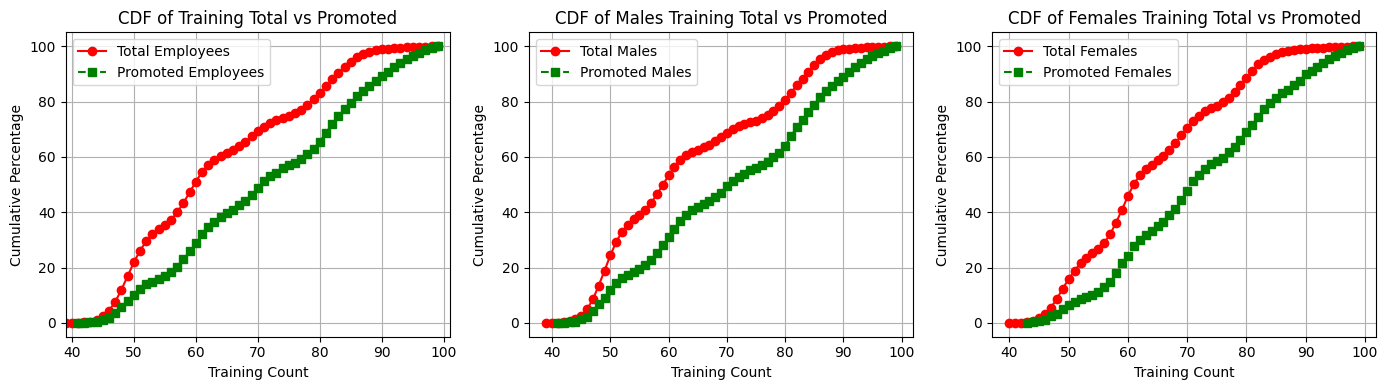

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Total employees
total_employees = len(train)

# Percentage of employees in each number of trainings category
trainings_counts = train['avg_training_score'].value_counts().sort_index()
percentage_trainings = (trainings_counts / total_employees) * 100
cumulative_percentage_trainings = np.cumsum(percentage_trainings)

# Percentage of male employees in each number of trainings category
male_counts_trainings = train[train['gender'] == 'Male']['avg_training_score'].value_counts().sort_index()
percentage_male_trainings = (male_counts_trainings / male_counts_trainings.sum()) * 100
cumulative_percentage_male_trainings = np.cumsum(percentage_male_trainings)

# Percentage of female employees in each number of trainings category
female_counts_trainings = train[train['gender'] == 'Female']['avg_training_score'].value_counts().sort_index()
percentage_female_trainings = (female_counts_trainings / female_counts_trainings.sum()) * 100
cumulative_percentage_female_trainings = np.cumsum(percentage_female_trainings)


# Filter data for promoted employees
promoted_data = train[train['is_promoted'] == 1]

# Total promoted employees
total_promoted = len(promoted_data)

# Percentage of promoted employees in each number of trainings category
trainings_counts_promoted = promoted_data['avg_training_score'].value_counts().sort_index()
percentage_promoted_trainings = (trainings_counts_promoted / total_promoted) * 100
cumulative_percentage_promoted_trainings = np.cumsum(percentage_promoted_trainings)

# Percentage of male promoted employees in each number of trainings category
male_counts_trainings_promoted = promoted_data[promoted_data['gender'] == 'Male']['avg_training_score'].value_counts().sort_index()
percentage_male_promoted_trainings = (male_counts_trainings_promoted / male_counts_trainings_promoted.sum()) * 100
cumulative_percentage_male_promoted_trainings = np.cumsum(percentage_male_promoted_trainings)

# Percentage of female promoted employees in each number of trainings category
female_counts_trainings_promoted = promoted_data[promoted_data['gender'] == 'Female']['avg_training_score'].value_counts().sort_index()
percentage_female_promoted_trainings = (female_counts_trainings_promoted / female_counts_trainings_promoted.sum()) * 100
cumulative_percentage_female_promoted_trainings = np.cumsum(percentage_female_promoted_trainings)

# Plotting the cumulative distribution functions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # Create subplots

# Plotting for total employees
axes[0].plot(cumulative_percentage_trainings.index, cumulative_percentage_trainings.values, marker='o', color='red', linestyle='-', label='Total Employees')
axes[0].plot(cumulative_percentage_promoted_trainings.index, cumulative_percentage_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Employees')

axes[0].set_title('CDF of Training Total vs Promoted')
axes[0].set_xlabel('Training Count')
axes[0].set_ylabel('Cumulative Percentage')
axes[0].grid(True)
axes[0].set_xticks(np.arange(40, 101, 10))  # Set x-ticks to start from 40 to 100 with a gap of 10
axes[0].set_xlim(39, 101)  # Set the x-axis limit from 39 to 101
axes[0].legend()

# Total males vs Promoted Males
axes[1].plot(cumulative_percentage_male_trainings.index, cumulative_percentage_male_trainings.values, marker='o', color='red', linestyle='-', label='Total Males')
axes[1].plot(cumulative_percentage_male_promoted_trainings.index, cumulative_percentage_male_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Males')

axes[1].set_title('CDF of Males Training Total vs Promoted')
axes[1].set_xlabel('Training Count')
axes[1].set_ylabel('Cumulative Percentage')
axes[1].grid(True)
axes[0].set_xticks(np.arange(40, 101, 10))  # Set x-ticks to start from 40 to 100 with a gap of 10
axes[0].set_xlim(39, 101)  # Set the x-axis limit from 39 to 101
axes[1].legend()


# Plotting the cumulative distribution functions for promoted employees
axes[2].plot(cumulative_percentage_female_trainings.index, cumulative_percentage_female_trainings.values, marker='o', color='red', linestyle='-', label='Total Females')
axes[2].plot(cumulative_percentage_female_promoted_trainings.index, cumulative_percentage_female_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Females')

axes[2].set_title('CDF of Females Training Total vs Promoted')
axes[2].set_xlabel('Training Count')
axes[2].set_ylabel('Cumulative Percentage')
axes[2].grid(True)
axes[0].set_xticks(np.arange(40, 101, 10))  # Set x-ticks to start from 40 to 100 with a gap of 10
axes[0].set_xlim(39, 101)  # Set the x-axis limit from 39 to 101
axes[2].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


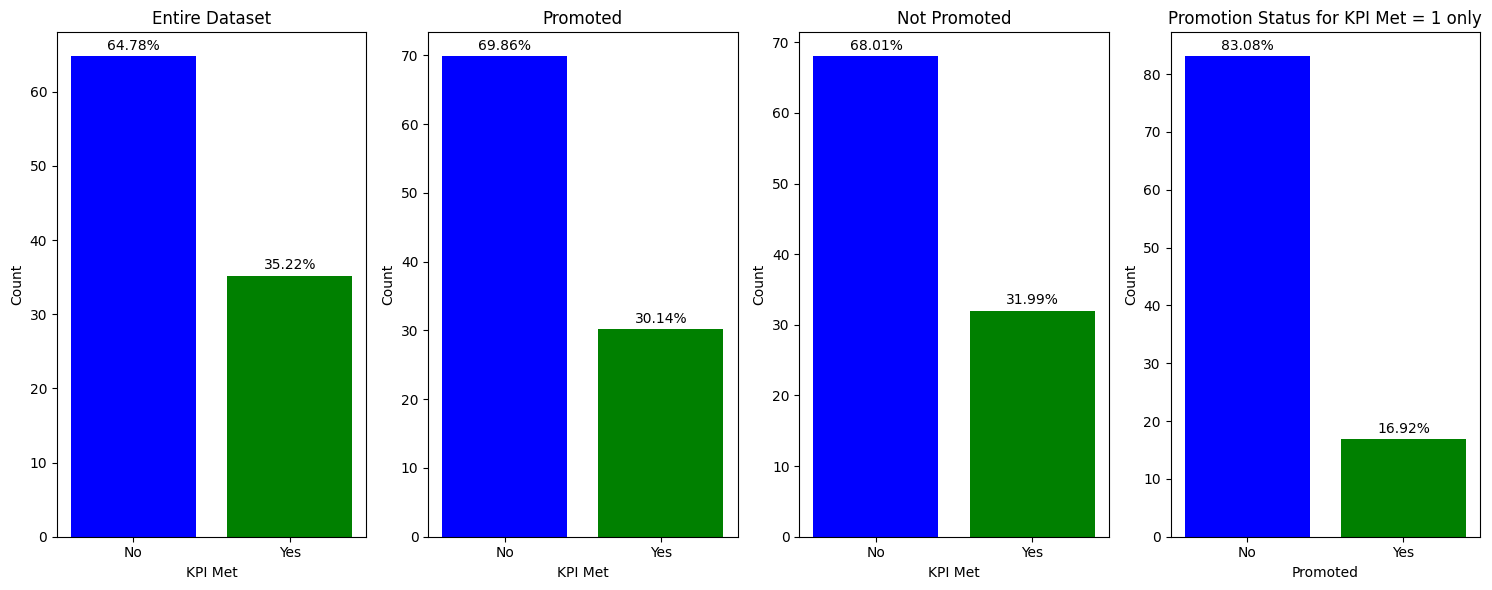

In [183]:
import matplotlib.pyplot as plt

# Filter DataFrame based on promotion status
promoted = train[train['is_promoted'] == 1]
not_promoted = train[train['is_promoted'] == 0]
kpi_met = train[train['KPI_met'] == 1]

# Count the number of males and females in each group
KPI_met_counts = train['KPI_met'].value_counts()
promoted_KPI_met_counts = promoted['KPI_met'].value_counts()
not_promoted_KPI_met_counts = not_promoted['KPI_met'].value_counts()
kpi_met_promotion_count = kpi_met['is_promoted'].value_counts()

# Calculate percentage values
KPI_met_percentage = (KPI_met_counts / KPI_met_counts.sum()) * 100
promoted_KPI_met_percentage = (promoted_KPI_met_counts / promoted_KPI_met_counts.sum()) * 100
not_promoted_KPI_met_percentage = (not_promoted_KPI_met_counts / not_promoted_KPI_met_counts.sum()) * 100
kpi_met_promotion_percentage = (kpi_met_promotion_count / kpi_met_promotion_count.sum()) * 100


# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Plot for entire dataset
bars = axes[0].bar(["No","Yes"], KPI_met_percentage.values, color=['blue', 'green'])
axes[0].set_title('Entire Dataset')
axes[0].set_xlabel('KPI Met')
axes[0].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(bars, KPI_met_percentage):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for promoted
promoted_bars = axes[1].bar(["No","Yes"], promoted_KPI_met_percentage.values, color=['blue', 'green'])
axes[1].set_title('Promoted')
axes[1].set_xlabel('KPI Met')
axes[1].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars, promoted_KPI_met_percentage):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for not promoted
not_promoted_bars = axes[2].bar(["No","Yes"], not_promoted_KPI_met_percentage.values, color=['blue', 'green'])
axes[2].set_title('Not Promoted')
axes[2].set_xlabel('KPI Met')
axes[2].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(not_promoted_bars, not_promoted_KPI_met_percentage):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for not promoted
not_promoted_bars = axes[3].bar(["No","Yes"], kpi_met_promotion_percentage.values, color=['blue', 'green'])
axes[3].set_title('Promotion Status for KPI Met = 1 only')
axes[3].set_xlabel('Promoted')
axes[3].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(not_promoted_bars, kpi_met_promotion_percentage):
    axes[3].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


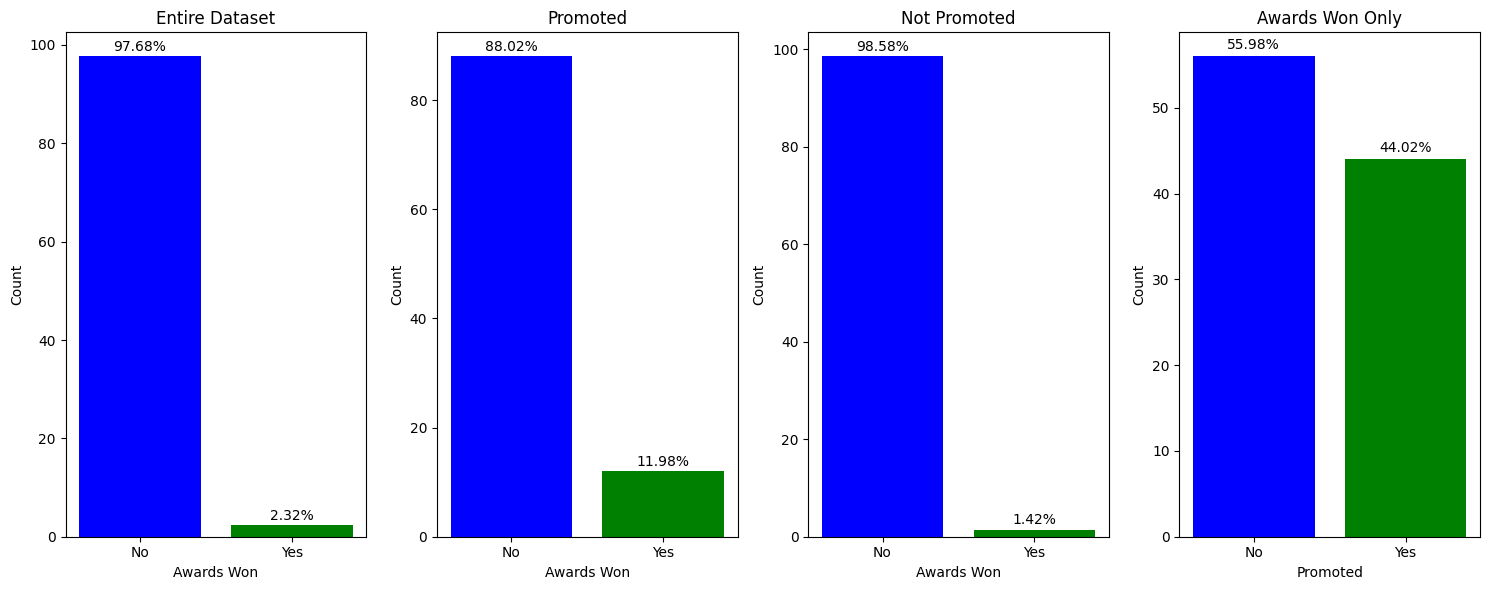

In [74]:
import matplotlib.pyplot as plt

# Filter DataFrame based on promotion status
promoted = train[train['is_promoted'] == 1]
not_promoted = train[train['is_promoted'] == 0]
awards_won = train[train['awards_won'] == 1]

# Count the number of males and females in each group
awards_won_counts = train['awards_won'].value_counts()
promoted_awards_won_counts = promoted['awards_won'].value_counts()
not_promoted_awards_won_counts = not_promoted['awards_won'].value_counts()
awards_won_promotion_count = awards_won['is_promoted'].value_counts()

# Calculate percentage values
awards_won_percentage = (awards_won_counts / awards_won_counts.sum()) * 100
promoted_awards_won_percentage = (promoted_awards_won_counts / promoted_awards_won_counts.sum()) * 100
not_promoted_awards_won_percentage = (not_promoted_awards_won_counts / not_promoted_awards_won_counts.sum()) * 100
awards_won_promotion_percentage = (awards_won_promotion_count / awards_won_promotion_count.sum()) * 100


# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Plot for entire dataset
bars = axes[0].bar(["No","Yes"], awards_won_percentage.values, color=['blue', 'green'])
axes[0].set_title('Entire Dataset')
axes[0].set_xlabel('Awards Won')
axes[0].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(bars, awards_won_percentage):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for promoted
promoted_bars = axes[1].bar(["No","Yes"], promoted_awards_won_percentage.values, color=['blue', 'green'])
axes[1].set_title('Promoted')
axes[1].set_xlabel('Awards Won')
axes[1].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars, promoted_awards_won_percentage):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for not promoted
not_promoted_bars = axes[2].bar(["No","Yes"], not_promoted_awards_won_percentage.values, color=['blue', 'green'])
axes[2].set_title('Not Promoted')
axes[2].set_xlabel('Awards Won')
axes[2].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(not_promoted_bars, not_promoted_awards_won_percentage):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for not promoted
not_promoted_bars = axes[3].bar(["No","Yes"], awards_won_promotion_percentage.values, color=['blue', 'green'])
axes[3].set_title('Awards Won Only')
axes[3].set_xlabel('Promoted')
axes[3].set_ylabel('Count')

# Add labels above the bars with percentage values
for bar, percentage in zip(not_promoted_bars, awards_won_promotion_percentage):
    axes[3].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

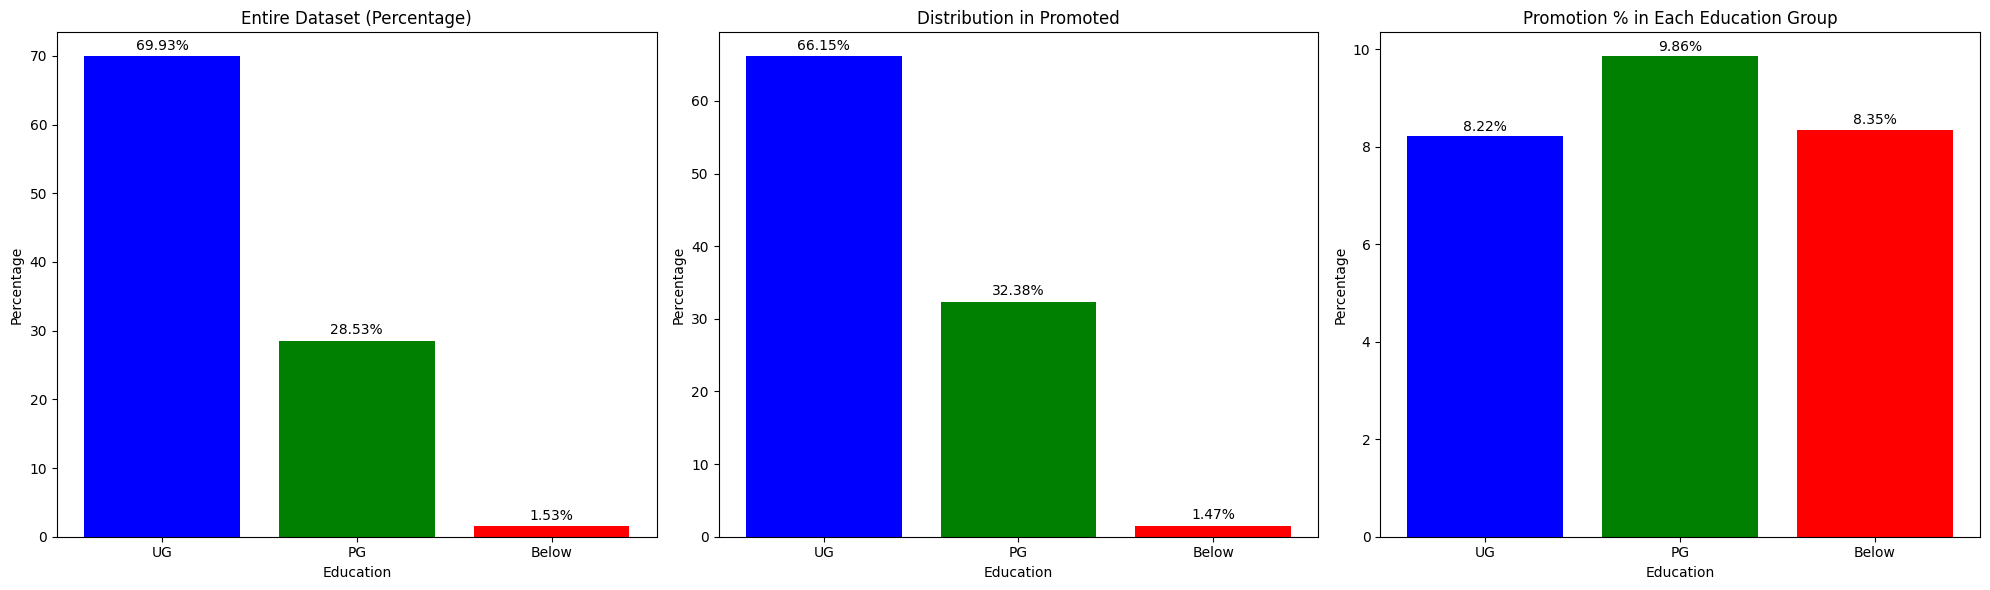

In [75]:
import matplotlib.pyplot as plt

# Filter DataFrame based on promotion status
promoted = train[train['is_promoted'] == 1]
education = train[train['education'] == 1]

# Count the number of each education level
education_counts = train['education'].value_counts()
promote_counts = promoted['education'].value_counts()
# Count the number of promoted employees for each education level
promoted_education_counts = promoted['education'].value_counts()

# Calculate percentage of each education level
education_percentage = (education_counts / education_counts.sum()) * 100

# Calculate percentage of promoted employees for each education level
promoted_education_percentage = (promoted_education_counts / promoted_education_counts.sum()) * 100

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Use 3 subplots for all charts

# Plot for entire dataset - Percentage
bars_entire_percentage = axes[0].bar(["UG","PG","Below"], education_percentage.values, color=['blue', 'green', 'red'])
axes[0].set_title('Entire Dataset (Percentage)')
axes[0].set_xlabel('Education')
axes[0].set_ylabel('Percentage')

# Add labels above the bars with percentage values
for bar, percentage in zip(bars_entire_percentage, education_percentage):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for promoted - Percentage
promoted_bars_percentage = axes[1].bar(["UG","PG","Below"], promoted_education_percentage.values, color=['blue', 'green', 'red'])
axes[1].set_title('Distribution in Promoted')
axes[1].set_xlabel('Education')
axes[1].set_ylabel('Percentage')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars_percentage, promoted_education_percentage):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for promoted - Percentage of each education level out of total count of that education level
education_promoted_percentage = promoted_education_counts / education_counts * 100
promoted_bars_counts_percentage = axes[2].bar(["UG","PG","Below"], education_promoted_percentage.values, color=['blue', 'green', 'red'])
axes[2].set_title('Promotion % in Each Education Group')
axes[2].set_xlabel('Education')
axes[2].set_ylabel('Percentage')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars_counts_percentage, education_promoted_percentage):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


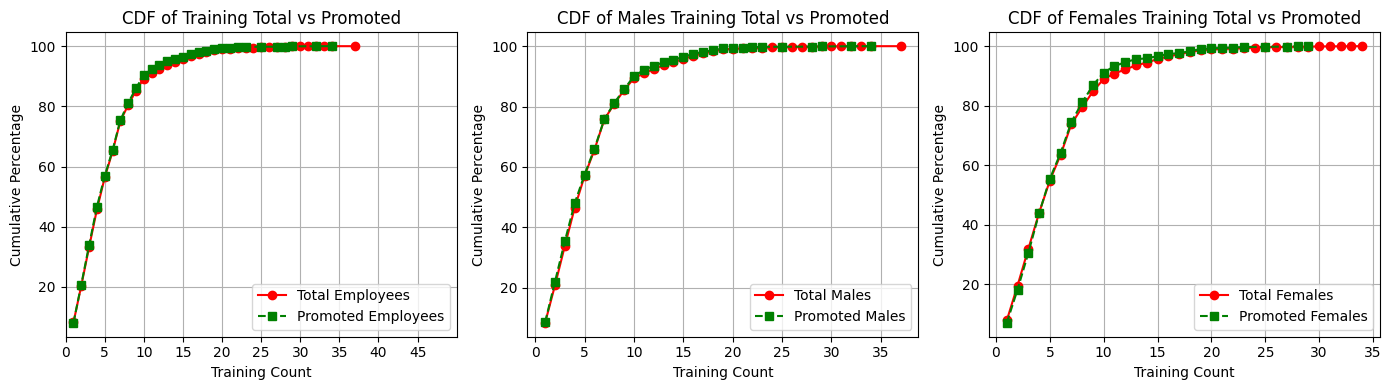

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Total employees
total_employees = len(train)

# Percentage of employees in each number of trainings category
trainings_counts = train['length_of_service'].value_counts().sort_index()
percentage_trainings = (trainings_counts / total_employees) * 100
cumulative_percentage_trainings = np.cumsum(percentage_trainings)

# Percentage of male employees in each number of trainings category
male_counts_trainings = train[train['gender'] == 'Male']['length_of_service'].value_counts().sort_index()
percentage_male_trainings = (male_counts_trainings / male_counts_trainings.sum()) * 100
cumulative_percentage_male_trainings = np.cumsum(percentage_male_trainings)

# Percentage of female employees in each number of trainings category
female_counts_trainings = train[train['gender'] == 'Female']['length_of_service'].value_counts().sort_index()
percentage_female_trainings = (female_counts_trainings / female_counts_trainings.sum()) * 100
cumulative_percentage_female_trainings = np.cumsum(percentage_female_trainings)


# Filter data for promoted employees
promoted_data = train[train['is_promoted'] == 1]

# Total promoted employees
total_promoted = len(promoted_data)

# Percentage of promoted employees in each number of trainings category
trainings_counts_promoted = promoted_data['length_of_service'].value_counts().sort_index()
percentage_promoted_trainings = (trainings_counts_promoted / total_promoted) * 100
cumulative_percentage_promoted_trainings = np.cumsum(percentage_promoted_trainings)

# Percentage of male promoted employees in each number of trainings category
male_counts_trainings_promoted = promoted_data[promoted_data['gender'] == 'Male']['length_of_service'].value_counts().sort_index()
percentage_male_promoted_trainings = (male_counts_trainings_promoted / male_counts_trainings_promoted.sum()) * 100
cumulative_percentage_male_promoted_trainings = np.cumsum(percentage_male_promoted_trainings)

# Percentage of female promoted employees in each number of trainings category
female_counts_trainings_promoted = promoted_data[promoted_data['gender'] == 'Female']['length_of_service'].value_counts().sort_index()
percentage_female_promoted_trainings = (female_counts_trainings_promoted / female_counts_trainings_promoted.sum()) * 100
cumulative_percentage_female_promoted_trainings = np.cumsum(percentage_female_promoted_trainings)

# Plotting the cumulative distribution functions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # Create subplots

# Plotting for total employees
axes[0].plot(cumulative_percentage_trainings.index, cumulative_percentage_trainings.values, marker='o', color='red', linestyle='-', label='Total Employees')
axes[0].plot(cumulative_percentage_promoted_trainings.index, cumulative_percentage_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Employees')

axes[0].set_title('CDF of Training Total vs Promoted')
axes[0].set_xlabel('Training Count')
axes[0].set_ylabel('Cumulative Percentage')
axes[0].grid(True)
axes[0].set_xticks(np.arange(0, 50, 5))  # Set x-ticks to start from 40 to 100 with a gap of 10
axes[0].set_xlim(0, 50)  # Set the x-axis limit from 39 to 101
axes[0].legend()

# Total males vs Promoted Males
axes[1].plot(cumulative_percentage_male_trainings.index, cumulative_percentage_male_trainings.values, marker='o', color='red', linestyle='-', label='Total Males')
axes[1].plot(cumulative_percentage_male_promoted_trainings.index, cumulative_percentage_male_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Males')

axes[1].set_title('CDF of Males Training Total vs Promoted')
axes[1].set_xlabel('Training Count')
axes[1].set_ylabel('Cumulative Percentage')
axes[1].grid(True)
axes[0].set_xticks(np.arange(0, 50, 5))  # Set x-ticks to start from 40 to 100 with a gap of 10
axes[0].set_xlim(0, 50)  # Set the x-axis limit from 39 to 101
axes[1].legend()


# Plotting the cumulative distribution functions for promoted employees
axes[2].plot(cumulative_percentage_female_trainings.index, cumulative_percentage_female_trainings.values, marker='o', color='red', linestyle='-', label='Total Females')
axes[2].plot(cumulative_percentage_female_promoted_trainings.index, cumulative_percentage_female_promoted_trainings.values, marker='s', color='green', linestyle='--', label='Promoted Females')

axes[2].set_title('CDF of Females Training Total vs Promoted')
axes[2].set_xlabel('Training Count')
axes[2].set_ylabel('Cumulative Percentage')
axes[2].grid(True)
axes[0].set_xticks(np.arange(0, 50, 5))  # Set x-ticks to start from 40 to 100 with a gap of 10
axes[0].set_xlim(0, 50)  # Set the x-axis limit from 39 to 101
axes[2].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


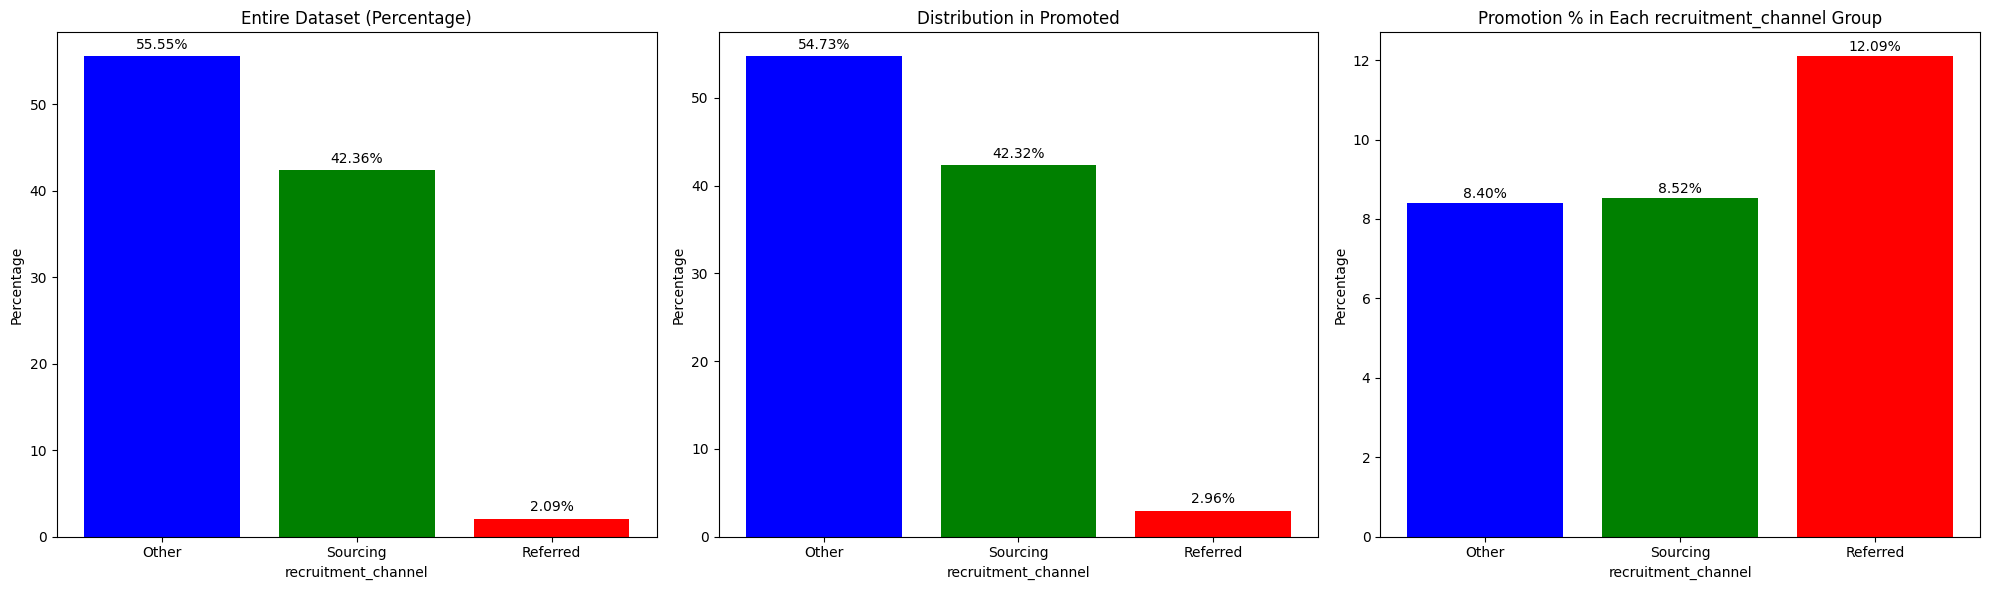

In [77]:
import matplotlib.pyplot as plt

# Filter DataFrame based on promotion status
promoted = train[train['is_promoted'] == 1]
recruitment_channel = train[train['recruitment_channel'] == 1]

# Count the number of each recruitment_channel level
recruitment_channel_counts = train['recruitment_channel'].value_counts()
promote_counts = promoted['recruitment_channel'].value_counts()
# Count the number of promoted employees for each recruitment_channel level
promoted_recruitment_channel_counts = promoted['recruitment_channel'].value_counts()

# Calculate percentage of each recruitment_channel level
recruitment_channel_percentage = (recruitment_channel_counts / recruitment_channel_counts.sum()) * 100

# Calculate percentage of promoted employees for each recruitment_channel level
promoted_recruitment_channel_percentage = (promoted_recruitment_channel_counts / promoted_recruitment_channel_counts.sum()) * 100

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Use 3 subplots for all charts

# Plot for entire dataset - Percentage
bars_entire_percentage = axes[0].bar(["Other","Sourcing","Referred"], recruitment_channel_percentage.values, color=['blue', 'green', 'red'])
axes[0].set_title('Entire Dataset (Percentage)')
axes[0].set_xlabel('recruitment_channel')
axes[0].set_ylabel('Percentage')

# Add labels above the bars with percentage values
for bar, percentage in zip(bars_entire_percentage, recruitment_channel_percentage):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for promoted - Percentage
promoted_bars_percentage = axes[1].bar(["Other","Sourcing","Referred"], promoted_recruitment_channel_percentage.values, color=['blue', 'green', 'red'])
axes[1].set_title('Distribution in Promoted')
axes[1].set_xlabel('recruitment_channel')
axes[1].set_ylabel('Percentage')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars_percentage, promoted_recruitment_channel_percentage):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Plot for promoted - Percentage of each recruitment_channel level out of total count of that recruitment_channel level
recruitment_channel_promoted_percentage = promoted_recruitment_channel_counts / recruitment_channel_counts * 100
promoted_bars_counts_percentage = axes[2].bar(["Other","Sourcing","Referred"], recruitment_channel_promoted_percentage.values, color=['blue', 'green', 'red'])
axes[2].set_title('Promotion % in Each recruitment_channel Group')
axes[2].set_xlabel('recruitment_channel')
axes[2].set_ylabel('Percentage')

# Add labels above the bars with percentage values
for bar, percentage in zip(promoted_bars_counts_percentage, recruitment_channel_promoted_percentage):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{percentage:.2f}%', 
                 ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


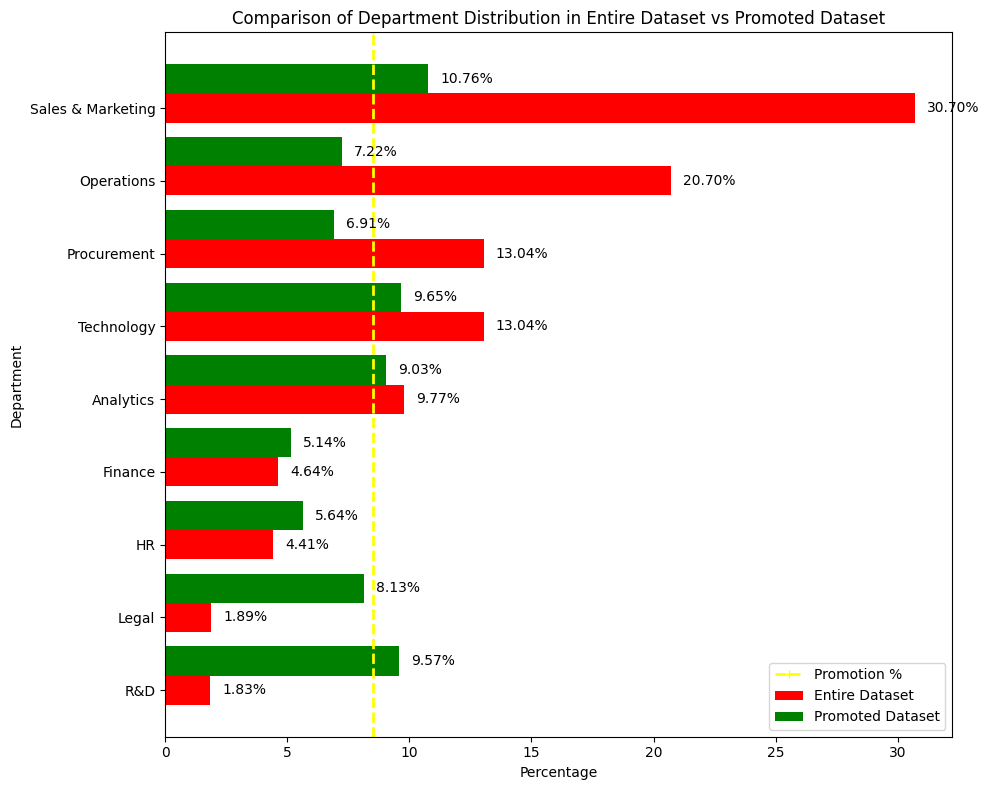

In [140]:
department_counts = train['department'].value_counts()
department_promote_counts = train[train['is_promoted']==1]['department'].value_counts()

bar_width = 0.4

department_indices = range(len(department_counts))  # Indices for department bars
promoted_indices = [index + bar_width for index in department_indices]  # Indices for promoted bars

# Sort the department counts in descending order of values
department_counts = department_counts.sort_values(ascending=True)
department_promote_counts = department_promote_counts.sort_values(ascending=True)

# Calculate percentage of each department level
department_percentage = (department_counts / department_counts.sum()) * 100
promoted_department_percentage = (department_promote_counts / department_counts) * 100
# prooted in respective department / total in resective department

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot bars for entire dataset
bars_entire_percentage = ax.barh(department_indices, department_percentage.values, bar_width, color='red', label='Entire Dataset')
# Plot bars for promoted dataset
promoted_bars_percentage = ax.barh(promoted_indices, promoted_department_percentage.values, bar_width, color='green', label='Promoted Dataset')

# Set y-tick labels to department names
ax.set_yticks(department_indices)
ax.set_yticklabels(department_counts.index)

# Add labels beside the bars with percentage values for entire dataset
for bar, percentage in zip(bars_entire_percentage, department_percentage):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
            ha='left', va='center')

# Add labels beside the bars with percentage values for promoted dataset
for bar, percentage in zip(promoted_bars_percentage, promoted_department_percentage):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
            ha='left', va='center')

# Set title and labels
ax.set_title('Comparison of Department Distribution in Entire Dataset vs Promoted Dataset')
ax.set_xlabel('Percentage')
ax.set_ylabel('Department')

# Add legend

ax.axvline(x=8.53, color='yellow', linewidth=2,linestyle='--', marker='+',label='Promotion %')
ax.legend(['Promotion %','Entire Dataset', 'Promoted Dataset'])
# Show plot
plt.tight_layout()
plt.show()


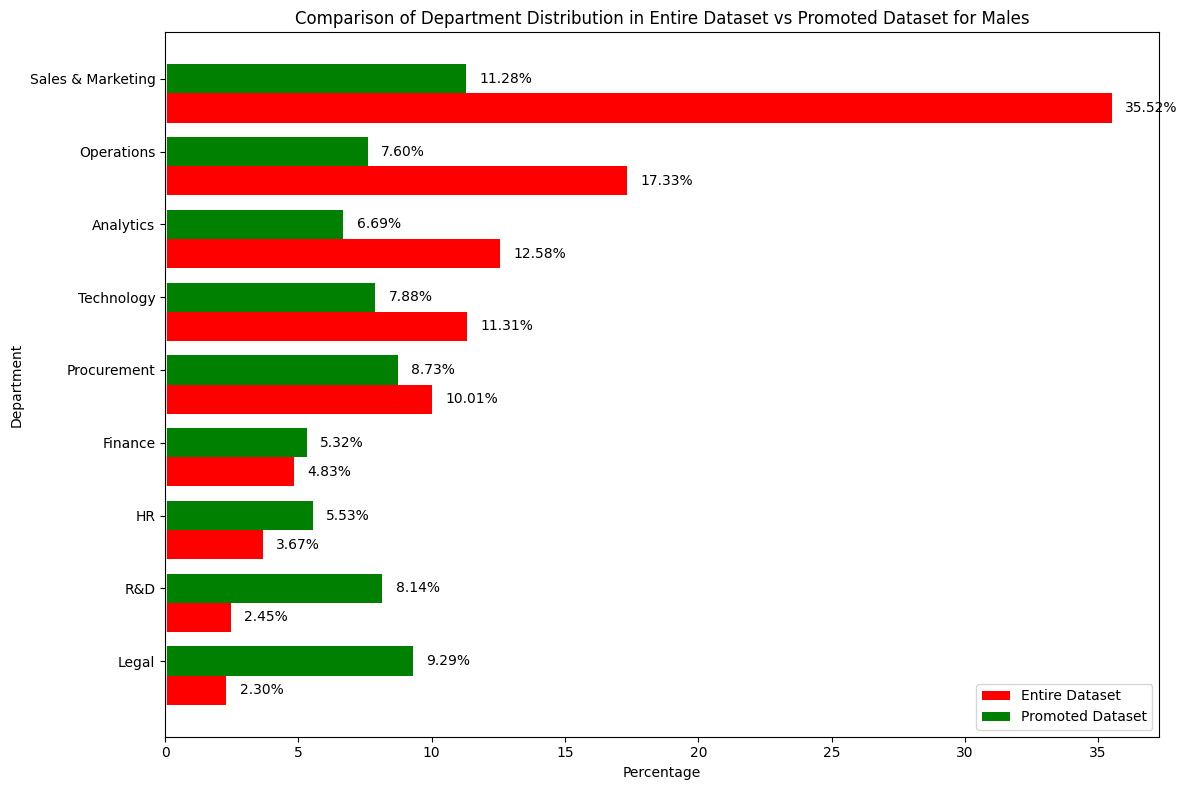

In [174]:
target_m = train[train.gender == 'Male']


department_counts_m = target_m['department'].value_counts()
department_promote_counts_m = target_m[target_m['is_promoted']==1]['department'].value_counts()

# Set positions for the bars
bar_width = 0.4  # Width of each bar
department_indices_m = range(len(department_counts_m))  # Indices for department bars
promoted_indices_m = [index + bar_width for index in department_indices_m]  # Indices for promoted bars

# Sort the department counts in descending order of values
department_counts_m = department_counts_m.sort_values(ascending=True)
department_promote_counts_m = department_promote_counts_m.sort_values(ascending=True)

# Calculate percentage of each department level
department_percentage_m = (department_counts_m / department_counts_m.sum()) * 100
promoted_department_percentage_m = (department_promote_counts_m / department_counts_m) * 100


# Plotting
fig, axes = plt.subplots(figsize=(12, 8))  # Use a single plot

# Plot bars for entire dataset
bars_entire_percentage_m = axes.barh(department_indices_m, department_percentage_m.values, bar_width, color='red', label='Entire Dataset')
# Plot bars for promoted dataset, shifting them to the right
promoted_bars_percentage_m = axes.barh(promoted_indices_m, promoted_department_percentage_m.values, bar_width, color='green', label='Promoted Dataset')

# Set y-ticks and labels
axes.set_yticks(promoted_indices_m)  # Set ticks at the center of the bars
axes.set_yticklabels(department_counts_m.index)  # Set department names as labels

# Add labels beside the bars with percentage values for entire dataset
for bar, percentage in zip(bars_entire_percentage_m, department_percentage_m):
    axes.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')


# Add labels beside the bars with percentage values for promoted dataset
for bar, percentage in zip(promoted_bars_percentage_m, promoted_department_percentage_m):
    axes.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')
    

# Set title and labels
axes.set_title('Comparison of Department Distribution in Entire Dataset vs Promoted Dataset for Males')
axes.set_xlabel('Percentage')
axes.set_ylabel('Department')

# Add legend
axes.legend(loc='lower right')
axes.axvline(x=0, color='white', linewidth=2)

# Show plot
plt.tight_layout()
plt.show()

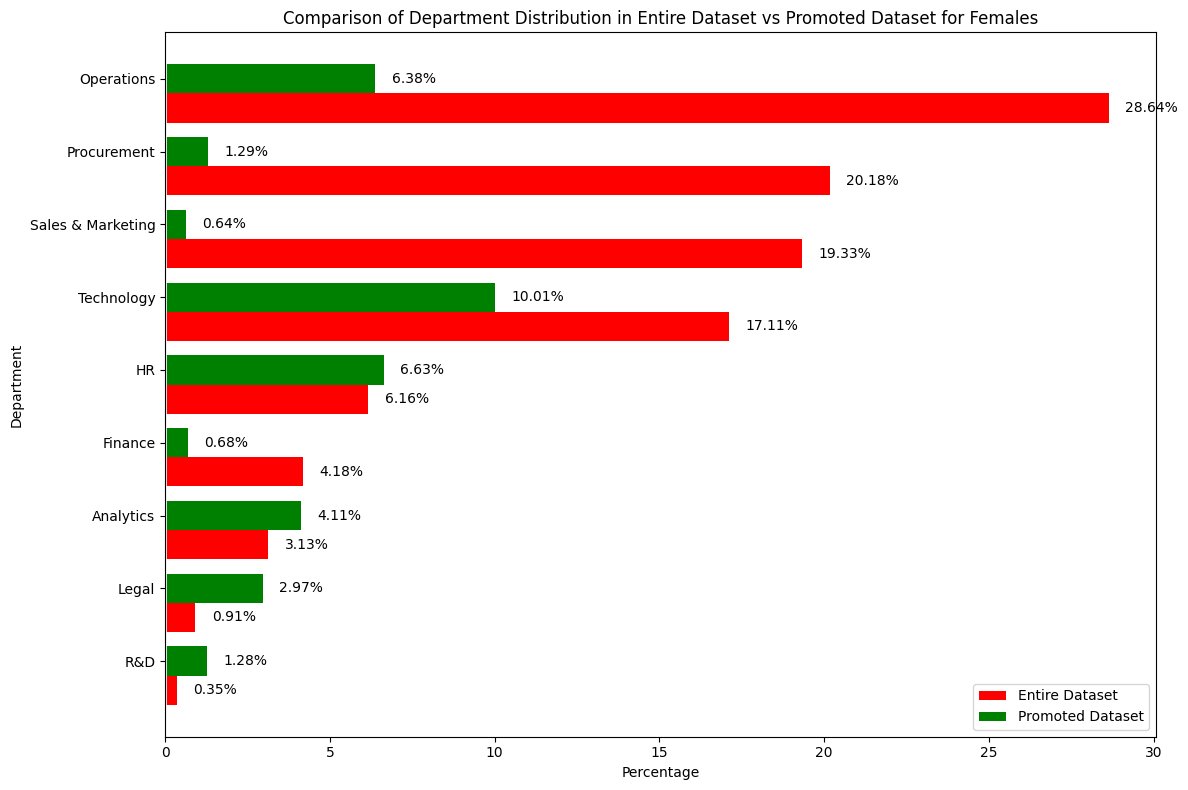

In [176]:

target_f = train[train.gender == 'Female']

# Set positions for the bars
bar_width = 0.4  # Width of each bar

department_counts_f = target_f['department'].value_counts()
department_promote_counts_f = target_f[target_f['is_promoted']==1]['department'].value_counts()

# Set positions for the bars
department_indices_f = range(len(department_counts_f))  # Indices for department bars
promoted_indices_f = [index + bar_width for index in department_indices_f]  # Indices for promoted bars

# Sort the department counts in descending order of values
department_counts_f = department_counts_f.sort_values(ascending=True)
department_promote_counts_f = department_promote_counts_f.sort_values(ascending=True)

# Calculate percentage of each department level
department_percentage_f = (department_counts_f / department_counts_f.sum()) * 100
promoted_department_percentage_f = (department_promote_counts_f / department_counts_m) * 100
# prooted in respective department / total in resective department


# Plotting
fig, axes = plt.subplots(figsize=(12, 8))  # Use a single plot

# Negative x axis
bars_entire_percentage_f = axes.barh(department_indices_f, department_percentage_f.values, bar_width, color='red', label='Entire Dataset')
# Plot bars for promoted dataset, shifting them to the right
promoted_bars_percentage_f = axes.barh(promoted_indices_f, promoted_department_percentage_f.values, bar_width, color='green', label='Promoted Dataset')

# Set y-ticks and labels
axes.set_yticks(promoted_indices_f)  # Set ticks at the center of the bars
axes.set_yticklabels(department_counts_f.index)  # Set department names as labels

# Add labels beside the bars with percentage values for entire dataset

for bar, percentage in zip(bars_entire_percentage_f, department_percentage_f):
    axes.text(bar.get_width() +0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')


for bar, percentage in zip(promoted_bars_percentage_f, promoted_department_percentage_f):
    axes.text(bar.get_width() +0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')
    

# Set title and labels
axes.set_title('Comparison of Department Distribution in Entire Dataset vs Promoted Dataset for Females')
axes.set_xlabel('Percentage')
axes.set_ylabel('Department')

# Add legend
axes.legend(loc='lower right')
axes.axvline(x=0, color='white', linewidth=2)

# Show plot
plt.tight_layout()
plt.show()

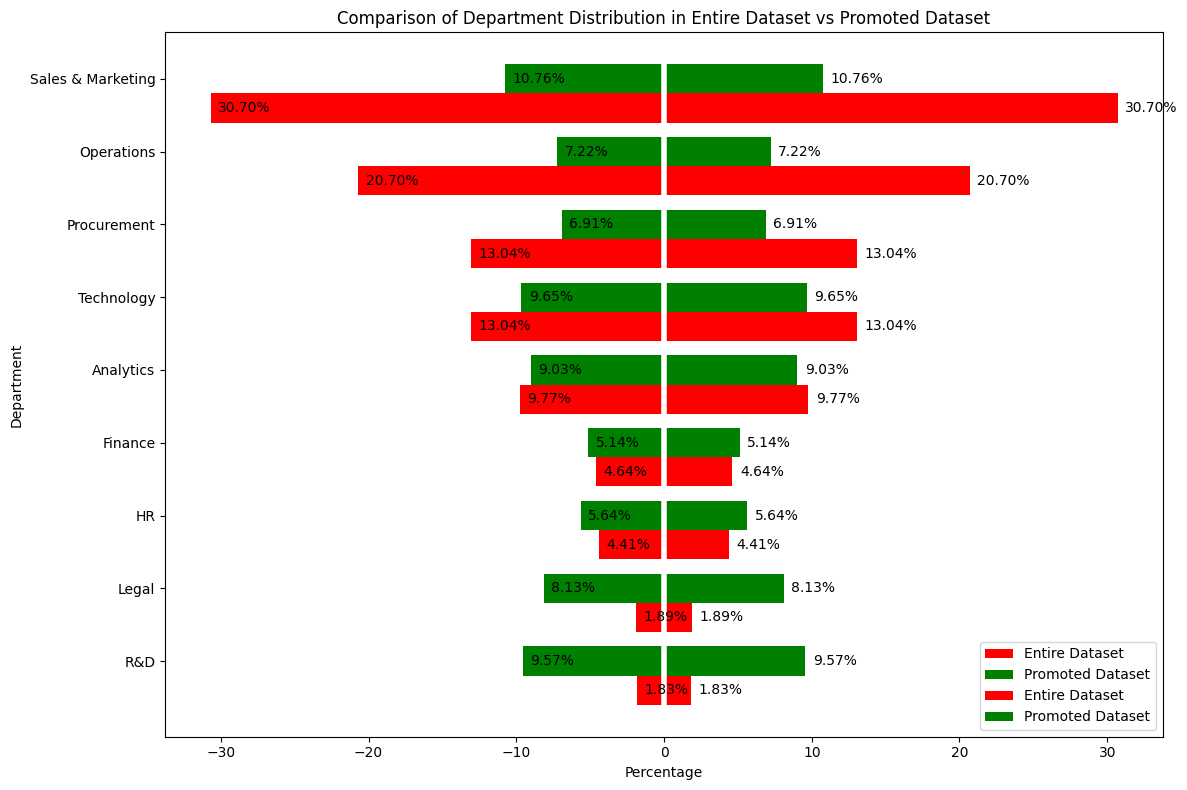

In [145]:
# Plotting
fig, axes = plt.subplots(figsize=(12, 8))  # Use a single plot

# Set positions for the bars
bar_width = 0.4  # Width of each bar
department_indices = range(len(department_counts))  # Indices for department bars
promoted_indices = [index + bar_width for index in department_indices]  # Indices for promoted bars

# Plot bars for entire dataset
bars_entire_percentage = axes.barh(department_indices, department_percentage.values, bar_width, color='red', label='Entire Dataset')
# Plot bars for promoted dataset, shifting them to the right
promoted_bars_percentage = axes.barh(promoted_indices, promoted_department_percentage.values, bar_width, color='green', label='Promoted Dataset')

# Negative x axis
bars_entire_percentage = axes.barh(department_indices, -department_percentage.values, bar_width, color='red', label='Entire Dataset')
# Plot bars for promoted dataset, shifting them to the right
promoted_bars_percentage = axes.barh(promoted_indices, -promoted_department_percentage.values, bar_width, color='green', label='Promoted Dataset')

# Set y-ticks and labels
axes.set_yticks(promoted_indices)  # Set ticks at the center of the bars
axes.set_yticklabels(department_counts.index)  # Set department names as labels

# Add labels beside the bars with percentage values for entire dataset
for bar, percentage in zip(bars_entire_percentage, department_percentage):
    axes.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')
    axes.text(-bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')

# Add labels beside the bars with percentage values for promoted dataset
for bar, percentage in zip(promoted_bars_percentage, promoted_department_percentage):
    axes.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')
    axes.text(-bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
              ha='left', va='center')

# Set title and labels
axes.set_title('Comparison of Department Distribution in Entire Dataset vs Promoted Dataset')
axes.set_xlabel('Percentage')
axes.set_ylabel('Department')

# Add legend
axes.legend(loc='lower right')
axes.axvline(x=0, color='white', linewidth=4)

# Show plot
plt.tight_layout()
plt.show()

### Further Steps
1. Prepare a dashboard about the EDA (Excel + PowerBI + Tableau)
2. Since there is a resemblance in missing value of previous_year_rating in both train and test set so that can be imputed
   before train-test split
3. Split the training dataset in trainset and validation set before doing any feature engineering or data preprocessing.
   This is needed to avoid any type of information leakage from training to validation set. If this is not done we are highly likely to get high validation F1 score but low F1 in actual test set.
4. Add EDA charts for Engineered features